In [557]:
from tensorflow import keras
from kdg.utils import generate_spirals, generate_gaussian_parity, generate_polynomial, generate_sinewave
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt

In [558]:
# create training, validation, and testing data

# spiral
X, y = generate_spirals(10000, noise=0.8, n_class=2)
X_val, y_val = generate_spirals(500, noise=0.8, n_class=2)
X_test, y_test = generate_spirals(1000, noise=0.8, n_class=2)

# ellipse
# X, y = generate_ellipse(10000)
# X_val, y_val = generate_ellipse(500)
# X_test, y_test = generate_ellipse(1000)

# gaussian parity
# X, y = generate_gaussian_parity(10000)
# X_val, y_val = generate_gaussian_parity(500)
# X_test, y_test = generate_gaussian_parity(1000)

# polynomial
# X, y = generate_polynomial(10000, a=(1, 3))
# X_val, y_val = generate_polynomial(500, a=(1, 3))
# X_test, y_test = generate_polynomial(1000, a=(1, 3))

# sinewave 
# X, y = generate_sinewave(10000, sigma=0.25)
# X_val, y_val = generate_sinewave(500, sigma=0.25)
# X_test, y_test = generate_sinewave(1000, sigma=0.25)

In [559]:
# Define NN parameters
compile_kwargs = {
    "loss": "binary_crossentropy",
    "optimizer": keras.optimizers.Adam(3e-4),
}
callback = keras.callbacks.EarlyStopping(monitor="val_loss", patience=10, verbose=True)
fit_kwargs = {
    "epochs": 300,
    "batch_size": 64,
    "verbose": False,
    "validation_data": (X_val, keras.utils.to_categorical(y_val)),
    "callbacks": [callback],
}

In [560]:
# define the network architecture

# # spiral
def getNN():
    network_base = keras.Sequential()
    initializer = keras.initializers.GlorotNormal(seed=0)
    network_base.add(keras.layers.Dense(10, activation="relu", kernel_initializer=initializer, input_shape=(2,)))
    network_base.add(keras.layers.Dense(10, activation="relu", kernel_initializer=initializer))
    network_base.add(keras.layers.Dense(10, activation="relu", kernel_initializer=initializer))
    network_base.add(keras.layers.Dense(5, activation="relu", kernel_initializer=initializer))
    network_base.add(keras.layers.Dense(units=2, activation="softmax", kernel_initializer=initializer))
    network_base.compile(**compile_kwargs)
    return network_base

# ellipse
# def getNN():
#     initializer = keras.initializers.GlorotNormal(seed=0)
#     network_base = keras.Sequential()
#     network_base.add(keras.layers.Dense(10, activation="relu", kernel_initializer=initializer, input_shape=(2,)))
#     network_base.add(keras.layers.Dense(10, activation="relu", kernel_initializer=initializer))
#     network_base.add(keras.layers.Dense(10, activation="relu", kernel_initializer=initializer))
#     network_base.add(keras.layers.Dense(5, activation="relu", kernel_initializer=initializer))
#     network_base.add(keras.layers.Dense(units=2, activation="softmax", kernel_initializer=initializer ))
#     network_base.compile(**compile_kwargs)
#     return network_base

# gaussian parity
# def getNN():
#     initializer = keras.initializers.GlorotNormal(seed=0)
#     network_base = keras.Sequential()
#     network_base.add(keras.layers.Dense(5, activation="relu", kernel_initializer=initializer, input_shape=(2,)))
#     network_base.add(keras.layers.Dense(5, activation="relu", kernel_initializer=initializer))
#     network_base.add(keras.layers.Dense(units=2, activation="softmax", kernel_initializer=initializer))
#     network_base.compile(**compile_kwargs)
#     return network_base

# polynomial
# def getNN():
#     initializer = keras.initializers.GlorotNormal(seed=0)
#     network_base = keras.Sequential()
#     network_base.add(keras.layers.Dense(6, activation="relu", kernel_initializer=initializer, input_shape=(2,)))
#     network_base.add(keras.layers.Dense(6, activation="relu", kernel_initializer=initializer))
#     network_base.add(keras.layers.Dense(6, activation="relu", kernel_initializer=initializer))
#     network_base.add(keras.layers.Dense(units=2, activation="softmax", kernel_initializer=initializer ))
#     network_base.compile(**compile_kwargs)
#     return network_base

# sinewave
# def getNN():
#     network_base = keras.Sequential()
#     network_base.add(keras.layers.Dense(12, activation="relu", input_shape=(2,)))
#     network_base.add(keras.layers.Dense(12, activation="relu"))
#     network_base.add(keras.layers.Dense(12, activation="relu"))
#     network_base.add(keras.layers.Dense(12, activation="relu"))
#     # network_base.add(keras.layers.Dense(10, activation="relu"))
#     network_base.add(keras.layers.Dense(units=2, activation="softmax"))
#     network_base.compile(**compile_kwargs)
#     return network_base

In [561]:
# train Vanilla NN
nn = getNN()
history = nn.fit(X, keras.utils.to_categorical(y), **fit_kwargs)

Epoch 00138: early stopping


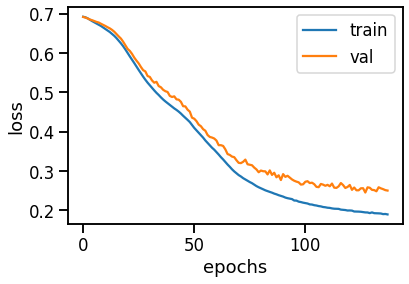

In [562]:
# plot the training loss and validation loss
fig, ax = plt.subplots()
ax.plot(history.history["loss"])
ax.plot(history.history["val_loss"])
ax.set_xlabel("epochs")
ax.set_ylabel("loss")
ax.legend(["train", "val"])

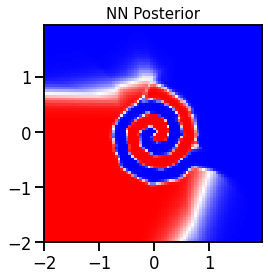

In [563]:
# plot the NN posterior
p = np.arange(-2, 2, step=0.05)
q = np.arange(-2, 2, step=0.05)
xx, yy = np.meshgrid(p, q)
tmp = np.ones(xx.shape)

grid_samples = np.concatenate((xx.reshape(-1, 1), yy.reshape(-1, 1)), axis=1)

proba_nn = nn.predict(grid_samples)

fig, ax = plt.subplots()
ax1 = ax.imshow(
        proba_nn[:, 0].reshape(80, 80).T,
        extent=[xx.min(), xx.max(), yy.min(), yy.max()],
        cmap="bwr",
        vmin=0,
        vmax=1,
        interpolation="nearest",
        aspect="auto",
    )
ax.set_title("NN Posterior", fontsize=15)
ax.set_aspect("equal")


## KDN with Penultimate layer-polytopes (Unweighted)

In [514]:
#
# Created on Thu Dec 09 2021 5:59:36 AM
# Author: Ashwin De Silva (ldesilv2@jhu.edu)
# Objective: Implements the KDN class
#

# import standard libraries
from sklearn.utils.validation import check_array, check_X_y
import numpy as np
from scipy.stats import multivariate_normal
from sklearn.covariance import LedoitWolf
import matplotlib.pyplot as plt


class kdn_pen_unw():
    def __init__(
        self,
        network,
        k=1,
        polytope_compute_method="all",
        weighting_method="lin",
        T=2,
        c=1,
        verbose=True,
    ):
        """Kernel Density Network

        Parameters
        ----------
        network : Keras Model
            trained neural network model
        k : int, optional
            bias tuning parameter, by default 1
        polytope_compute_method : str, optional
            select the polytope compute method, by default 'all'
        T : int, optional
            polytope size threshold, by default 2
        c : int, optional
            weight tuning parameter, by default 1
        weighting : bool, optional
            select the weighting scheme, by default True
        verbose : bool, optional
            display meta data, by default True
        """

        super().__init__()
        self.polytope_means = {}
        self.polytope_cov = {}
        self.network = network
        self.k = k
        self.c = c
        self.polytope_compute_method = polytope_compute_method
        self.T = T
        self.weighting_method = weighting_method
        self.bias = {}
        self.verbose = verbose

        # total number of layers in the NN
        self.total_layers = len(self.network.layers)

        # get the layer sizes of each layer
        self.network_shape = []
        for layer in network.layers:
            self.network_shape.append(layer.output_shape[-1])

        # get the weights and biases of the trained MLP
        self.weights = {}
        self.biases = {}
        for i in range(len(self.network.layers)):
            weight, bias = self.network.layers[i].get_weights()
            self.weights[i], self.biases[i] = weight, bias.reshape(1, -1)

    def _get_polytope_memberships(self, X):
        r"""
        Obtain the polytope ID of each input sample
        Parameters
        ----------
        X : ndarray
            Input data matrix.
        """
        polytope_memberships = []
        last_activations = X

        # Iterate through neural network manually, getting node activations at each step
        for layer_id in range(self.total_layers):
            weights, bias = self.network.layers[layer_id].get_weights()

            # Calculate new activations based on input to this layer
            preactivation = np.matmul(last_activations, weights) + bias

            # get list of activated nodes in this layer
            if layer_id == self.total_layers - 1:
                binary_preactivation = (preactivation > 0.5).astype("int")
            else:
                binary_preactivation = (preactivation > 0).astype("int")

            if self.polytope_compute_method == "pl":
                # determine the polytope memberships only based on the penultimate layer (uncomment )
                if layer_id == self.total_layers - 2:
                    polytope_memberships.append(binary_preactivation)

            if self.polytope_compute_method == "all":
                # determine the polytope memberships only based on all the FC layers (uncomment)
                if layer_id < self.total_layers - 1:
                    polytope_memberships.append(binary_preactivation)

            # remove all nodes that were not activated
            last_activations = preactivation * binary_preactivation

        # Concatenate all activations for given observation
        polytope_obs = np.concatenate(polytope_memberships, axis=1)
        polytope_memberships = [
            np.tensordot(
                polytope_obs, 2 ** np.arange(0, np.shape(polytope_obs)[1]), axes=1
            )
        ]

        self.num_fc_neurons = polytope_obs.shape[
            1
        ]  # get the number of total FC neurons under consideration

        return polytope_memberships

    def _get_activation_pattern(self, polytope_id):
        """get the ReLU activation pattern given the polytope ID

        Parameters
        ----------
        polytope_id : int
            polytope identifier

        Returns
        -------
        ndarray
            ReLU activation pattern (binary) corresponding to the given polytope ID
        """
        binary_string = np.binary_repr(polytope_id, width=self.num_fc_neurons)[::-1]
        return np.array(list(binary_string)).astype("int")
        
    def compute_weights(self, X_, polytope_id):
        """compute weights based on the global network linearity measure

        Parameters
        ----------
        X_ : ndarray
            Input data matrix
        polytope_id : int
            refernce polytope identifier

        Returns
        -------
        ndarray
            weights of each input sample in the input data matrix
        """
        
        M_ref = self._get_activation_pattern(polytope_id)

        start = 0
        A = X_
        A_ref = X_
        d = 0
        for l in range(len(self.network_shape)-1):
            end = start + self.network_shape[l]
            M_l = M_ref[start:end]
            start = end
            W, B = self.weights[l], self.biases[l]
            pre_A = A @ W + B
            A = np.maximum(0, pre_A)
            pre_A_ref = A_ref @ W + B
            A_ref = pre_A_ref @ np.diag(M_l) 
            d += np.linalg.norm(A - A_ref, axis=1, ord=2)

        return np.exp(-self.c * d)

    def fit(self, X, y):
        r"""
        Fits the kernel density network
        Parameters
        ----------
        X : ndarray
            Input data matrix.
        y : ndarray
            Output (i.e. response) data matrix.
        """
        X, y = check_X_y(X, y)
        self.labels = np.unique(y)

        feature_dim = X.shape[1]

        for label in self.labels:
            self.polytope_means[label] = []
            self.polytope_cov[label] = []

            X_ = X[np.where(y == label)[0]]
            polytope_memberships = self._get_polytope_memberships(X_)[0]
            unique_polytope_ids = np.unique(
                polytope_memberships
            )  # get the unique polytopes

            if self.verbose:
                print("Number of Polytopes : ", len(polytope_memberships))
                print("Number of Unique Polytopes : ", len(unique_polytope_ids))

            polytope_member_count = []  # store the polytope member counts

            for (
                idxx
            ) in range(
                len(polytope_memberships)
            ):  # fit Gaussians for each unique non-singleton polytopes

                idx = np.where(polytope_memberships == polytope_memberships[idxx])[0]

                polytope_size = len(idx)
                polytope_member_count.append(polytope_size)

                if (
                    polytope_size < self.T
                ):  # eliminate polytopes with too few samples within
                    continue

                scales = np.ones((len(idx), ))

                # apply weights to the data
                X_tmp = X_[idx].copy()
                polytope_mean_ = np.average(
                    X_tmp, axis=0, weights=scales
                )  # compute the weighted average of the samples
                X_tmp -= polytope_mean_  # center the data

                sqrt_scales = np.sqrt(scales).reshape(-1, 1) @ np.ones(
                    feature_dim
                ).reshape(1, -1)
                X_tmp *= sqrt_scales  # scale the centered data with the square root of the weights

                # compute the covariance matrix of the underlying Gaussian using Ledoit-Wolf estimator

                covariance_model = LedoitWolf(assume_centered=True)
                covariance_model.fit(X_tmp)
                polytope_cov_ = covariance_model.covariance_ * len(scales) / sum(scales)

                # store the mean and covariances
                self.polytope_means[label].append(polytope_mean_)
                self.polytope_cov[label].append(polytope_cov_)

            ## calculate bias for each label
            likelihoods = np.zeros((np.size(X_, 0)), dtype=float)

            for polytope_idx, _ in enumerate(self.polytope_means[label]):
                likelihoods += np.nan_to_num(self._compute_pdf(X_, label, polytope_idx))

            likelihoods /= X_.shape[0]
            self.bias[label] = np.min(likelihoods) / (self.k * X_.shape[0])

            if self.verbose:
                plt.hist(polytope_member_count, bins=30)
                plt.xlabel("Number of Members")
                plt.ylabel("Number of Polytopes")
                plt.show()

    def _compute_pdf(self, X, label, polytope_idx):
        """compute the likelihood for the given data

        Parameters
        ----------
        X : ndarray
            Input data matrix
        label : int
            class label
        polytope_idx : int
            polytope identifier

        Returns
        -------
        ndarray
            likelihoods
        """
        polytope_mean = self.polytope_means[label][polytope_idx]
        polytope_cov = self.polytope_cov[label][polytope_idx]

        var = multivariate_normal(
            mean=polytope_mean, cov=polytope_cov, allow_singular=True
        )

        likelihood = var.pdf(X)
        return likelihood

    def predict_proba(self, X):
        r"""
        Calculate posteriors using the kernel density forest.
        Parameters
        ----------
        X : ndarray
            Input data matrix.
        """
        X = check_array(X)

        likelihoods = np.zeros((np.size(X, 0), len(self.labels)), dtype=float)

        for ii, label in enumerate(self.labels):
            total_polytopes = len(self.polytope_means[label])
            for polytope_idx, _ in enumerate(self.polytope_means[label]):
                likelihoods[:, ii] += np.nan_to_num(
                    self._compute_pdf(X, label, polytope_idx)
                )

            likelihoods[:, ii] = likelihoods[:, ii] / total_polytopes
            likelihoods[:, ii] += min(self.bias.values())

        proba = (likelihoods.T / (np.sum(likelihoods, axis=1) + 1e-100)).T
        return proba

    def predict_proba_nn(self, X):
        r"""
        Calculate posteriors using the vanilla NN
        Parameters
        ----------
        X : ndarray
            Input data matrix.
        """
        X = check_array(X)

        proba = self.network.predict(X)
        return proba

    def predict(self, X):
        r"""
        Perform inference using the kernel density forest.
        Parameters
        ----------
        X : ndarray
            Input data matrix.
        """
        return np.argmax(self.predict_proba(X), axis=1)


In [515]:
model_kdn = kdn_pen_unw(
    network=nn,
    polytope_compute_method='pl',
    k=1e-5,
    verbose=False
)
model_kdn.fit(X, y)

In [516]:
print(
    np.mean(model_kdn.predict(X_test)==y_test)
)

0.871


In [517]:
print(
    np.mean(np.argmax(nn.predict(X_test), axis=1) == y_test)
)

0.896


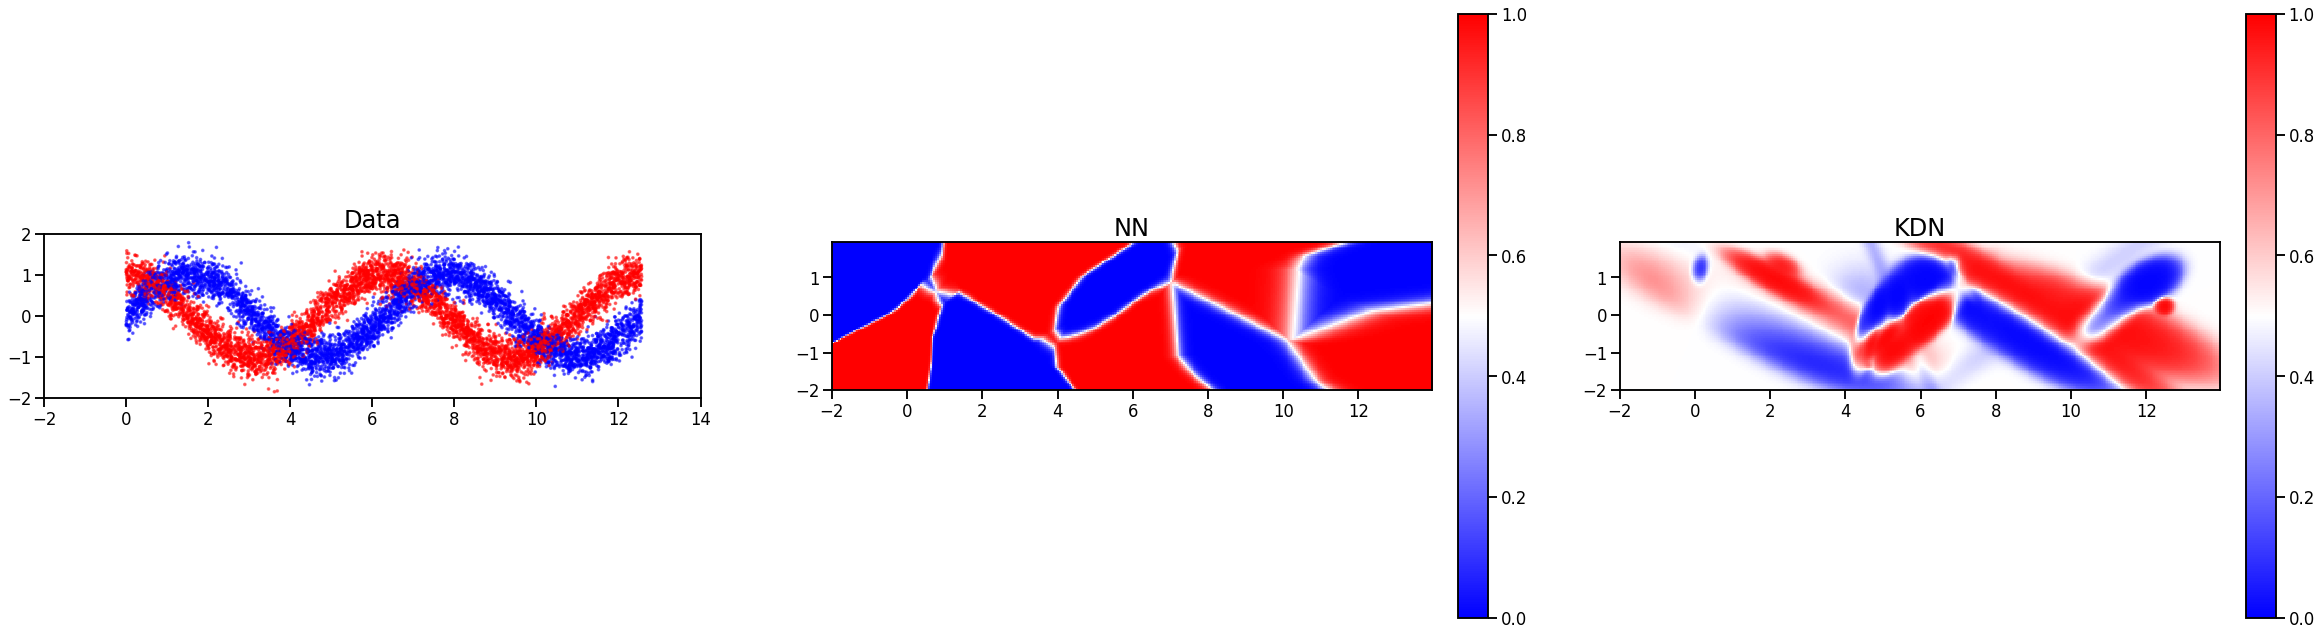

In [518]:
# plot

# define the grid
p = np.arange(-2, 14, step=0.05)
q = np.arange(-2, 2, step=0.05)
xx, yy = np.meshgrid(p, q)
tmp = np.ones(xx.shape)
grid_samples = np.concatenate((xx.reshape(-1, 1), yy.reshape(-1, 1)), axis=1)

# plot
proba_kdn = model_kdn.predict_proba(grid_samples)
proba_nn = model_kdn.predict_proba_nn(grid_samples)

fig, ax = plt.subplots(1, 3, figsize=(40, 40))

import matplotlib
cmap = matplotlib.cm.get_cmap('bwr')
clr = [cmap(255*i) for i in y]
ax[0].scatter(X[:, 0], X[:, 1], c=clr, s=5, alpha=0.5)
ax[0].set_xlim(-2, 14)
ax[0].set_ylim(-2, 2)
ax[0].set_title("Data", fontsize=24)
ax[0].set_aspect("equal")

ax1 = ax[1].imshow(
    np.flip(proba_nn[:, 0].reshape(80, 320), axis=0),
    extent=[xx.min(), xx.max(), yy.min(), yy.max()],
    cmap="bwr",
    vmin=0,
    vmax=1,
    interpolation="nearest",
    aspect="auto",
)
ax[1].set_title("NN", fontsize=24)
ax[1].set_aspect("equal")
fig.colorbar(ax1, ax=ax[1], fraction=0.046, pad=0.04)

ax2 = ax[2].imshow(
    np.flip(proba_kdn[:, 0].reshape(80, 320), axis=0),
    extent=[xx.min(), xx.max(), yy.min(), yy.max()],
    cmap="bwr",
    vmin=0,
    vmax=1,
    interpolation="nearest",
    aspect="auto",
)
ax[2].set_title("KDN", fontsize=24)
ax[2].set_aspect("equal")
fig.colorbar(ax2, ax=ax[2], fraction=0.046, pad=0.04)

fig.savefig("KDN_pen_unw.pdf", bbox_inches='tight')
plt.show()



## KDN with Penultimate layer-polytopes (Weighted)

In [529]:
#
# Created on Thu Dec 09 2021 5:59:36 AM
# Author: Ashwin De Silva (ldesilv2@jhu.edu)
# Objective: Implements the KDN class
#

# import standard libraries
from sklearn.utils.validation import check_array, check_X_y
import numpy as np
from scipy.stats import multivariate_normal
from sklearn.covariance import LedoitWolf
import matplotlib.pyplot as plt


class kdn_pen_w():
    def __init__(
        self,
        network,
        k=1,
        polytope_compute_method="all",
        weighting_method="lin",
        T=2,
        c=1,
        verbose=True,
    ):
        """Kernel Density Network

        Parameters
        ----------
        network : Keras Model
            trained neural network model
        k : int, optional
            bias tuning parameter, by default 1
        polytope_compute_method : str, optional
            select the polytope compute method, by default 'all'
        T : int, optional
            polytope size threshold, by default 2
        c : int, optional
            weight tuning parameter, by default 1
        weighting : bool, optional
            select the weighting scheme, by default True
        verbose : bool, optional
            display meta data, by default True
        """

        super().__init__()
        self.polytope_means = {}
        self.polytope_cov = {}
        self.network = network
        self.k = k
        self.c = c
        self.polytope_compute_method = polytope_compute_method
        self.T = T
        self.weighting_method = weighting_method
        self.bias = {}
        self.verbose = verbose

        # total number of layers in the NN
        self.total_layers = len(self.network.layers)

        # get the layer sizes of each layer
        self.network_shape = []
        for layer in network.layers:
            self.network_shape.append(layer.output_shape[-1])

        # get the weights and biases of the trained MLP
        self.weights = {}
        self.biases = {}
        for i in range(len(self.network.layers)):
            weight, bias = self.network.layers[i].get_weights()
            self.weights[i], self.biases[i] = weight, bias.reshape(1, -1)

    def _get_polytope_memberships(self, X):
        r"""
        Obtain the polytope ID of each input sample
        Parameters
        ----------
        X : ndarray
            Input data matrix.
        """
        polytope_memberships = []
        last_activations = X

        # Iterate through neural network manually, getting node activations at each step
        for layer_id in range(self.total_layers):
            weights, bias = self.network.layers[layer_id].get_weights()

            # Calculate new activations based on input to this layer
            preactivation = np.matmul(last_activations, weights) + bias

            # get list of activated nodes in this layer
            if layer_id == self.total_layers - 1:
                binary_preactivation = (preactivation > 0.5).astype("int")
            else:
                binary_preactivation = (preactivation > 0).astype("int")

            if self.polytope_compute_method == "pl":
                # determine the polytope memberships only based on the penultimate layer (uncomment )
                if layer_id == self.total_layers - 2:
                    polytope_memberships.append(binary_preactivation)

            if self.polytope_compute_method == "all":
                # determine the polytope memberships only based on all the FC layers (uncomment)
                if layer_id < self.total_layers - 1:
                    polytope_memberships.append(binary_preactivation)

            # remove all nodes that were not activated
            last_activations = preactivation * binary_preactivation

        # Concatenate all activations for given observation
        polytope_obs = np.concatenate(polytope_memberships, axis=1)
        polytope_memberships = [
            np.tensordot(
                polytope_obs, 2 ** np.arange(0, np.shape(polytope_obs)[1]), axes=1
            )
        ]

        self.num_fc_neurons = polytope_obs.shape[
            1
        ]  # get the number of total FC neurons under consideration

        return polytope_memberships

    def _get_activation_pattern(self, polytope_id):
        """get the ReLU activation pattern given the polytope ID

        Parameters
        ----------
        polytope_id : int
            polytope identifier

        Returns
        -------
        ndarray
            ReLU activation pattern (binary) corresponding to the given polytope ID
        """
        binary_string = np.binary_repr(polytope_id, width=self.num_fc_neurons)[::-1]
        return np.array(list(binary_string)).astype("int")
        
    def compute_weights(self, X, X_ref):
        """compute weights based on the global network linearity measure

        Parameters
        ----------
        X_ : ndarray
            Input data matrix
        polytope_id : int
            refernce polytope identifier

        Returns
        -------
        ndarray
            weights of each input sample in the input data matrix
        """

        A = X
        for l in range(len(self.network_shape)-1):
            W, B = self.weights[l], self.biases[l]
            pre_A = A @ W + B
            A = np.maximum(0, pre_A)
        
        A_ref = X_ref
        for l in range(len(self.network_shape)-1):
            W, B = self.weights[l], self.biases[l]
            pre_A_ref = A_ref @ W + B
            A_ref = np.maximum(0, pre_A_ref)

        d = np.linalg.norm(A - A_ref, axis=1, ord=2)
        return np.exp(-self.c * d)

    def fit(self, X, y):
        r"""
        Fits the kernel density network
        Parameters
        ----------
        X : ndarray
            Input data matrix.
        y : ndarray
            Output (i.e. response) data matrix.
        """
        X, y = check_X_y(X, y)
        self.labels = np.unique(y)

        feature_dim = X.shape[1]

        for label in self.labels:
            self.polytope_means[label] = []
            self.polytope_cov[label] = []

            X_ = X[np.where(y == label)[0]]
            polytope_memberships = self._get_polytope_memberships(X_)[0]
            unique_polytope_ids = np.unique(
                polytope_memberships
            )  # get the unique polytopes

            if self.verbose:
                print("Number of Polytopes : ", len(polytope_memberships))
                print("Number of Unique Polytopes : ", len(unique_polytope_ids))

            polytope_member_count = []  # store the polytope member counts

            for (
                idxx
            ) in range(
                len(polytope_memberships)
            ):  # fit Gaussians for each unique non-singleton polytopes

                idx = np.where(polytope_memberships == polytope_memberships[idxx])[0]

                polytope_size = len(idx)
                polytope_member_count.append(polytope_size)

                if (
                    polytope_size < self.T
                ):  # eliminate polytopes with too few samples within
                    continue

                # apply weights to the data
                X_tmp = X_[idx].copy()

                # compute scales
                scales = self.compute_weights(X_tmp, X_[idxx])

                polytope_mean_ = np.average(
                    X_tmp, axis=0, weights=scales
                )  # compute the weighted average of the samples
                X_tmp -= polytope_mean_  # center the data

                sqrt_scales = np.sqrt(scales).reshape(-1, 1) @ np.ones(
                    feature_dim
                ).reshape(1, -1)
                X_tmp *= sqrt_scales  # scale the centered data with the square root of the weights

                # compute the covariance matrix of the underlying Gaussian using Ledoit-Wolf estimator

                covariance_model = LedoitWolf(assume_centered=True)
                covariance_model.fit(X_tmp)
                polytope_cov_ = covariance_model.covariance_ * len(scales) / sum(scales)

                # store the mean and covariances
                self.polytope_means[label].append(polytope_mean_)
                self.polytope_cov[label].append(polytope_cov_)

            ## calculate bias for each label
            likelihoods = np.zeros((np.size(X_, 0)), dtype=float)

            for polytope_idx, _ in enumerate(self.polytope_means[label]):
                likelihoods += np.nan_to_num(self._compute_pdf(X_, label, polytope_idx))

            likelihoods /= X_.shape[0]
            self.bias[label] = np.min(likelihoods) / (self.k * X_.shape[0])

            if self.verbose:
                plt.hist(polytope_member_count, bins=30)
                plt.xlabel("Number of Members")
                plt.ylabel("Number of Polytopes")
                plt.show()

    def _compute_pdf(self, X, label, polytope_idx):
        """compute the likelihood for the given data

        Parameters
        ----------
        X : ndarray
            Input data matrix
        label : int
            class label
        polytope_idx : int
            polytope identifier

        Returns
        -------
        ndarray
            likelihoods
        """
        polytope_mean = self.polytope_means[label][polytope_idx]
        polytope_cov = self.polytope_cov[label][polytope_idx]

        var = multivariate_normal(
            mean=polytope_mean, cov=polytope_cov, allow_singular=True
        )

        likelihood = var.pdf(X)
        return likelihood

    def predict_proba(self, X):
        r"""
        Calculate posteriors using the kernel density forest.
        Parameters
        ----------
        X : ndarray
            Input data matrix.
        """
        X = check_array(X)

        likelihoods = np.zeros((np.size(X, 0), len(self.labels)), dtype=float)

        for ii, label in enumerate(self.labels):
            total_polytopes = len(self.polytope_means[label])
            for polytope_idx, _ in enumerate(self.polytope_means[label]):
                likelihoods[:, ii] += np.nan_to_num(
                    self._compute_pdf(X, label, polytope_idx)
                )

            likelihoods[:, ii] = likelihoods[:, ii] / total_polytopes
            likelihoods[:, ii] += min(self.bias.values())

        proba = (likelihoods.T / (np.sum(likelihoods, axis=1) + 1e-100)).T
        return proba

    def predict_proba_nn(self, X):
        r"""
        Calculate posteriors using the vanilla NN
        Parameters
        ----------
        X : ndarray
            Input data matrix.
        """
        X = check_array(X)

        proba = self.network.predict(X)
        return proba

    def predict(self, X):
        r"""
        Perform inference using the kernel density forest.
        Parameters
        ----------
        X : ndarray
            Input data matrix.
        """
        return np.argmax(self.predict_proba(X), axis=1)


In [530]:
model_kdn = kdn_pen_w(
    network=nn,
    polytope_compute_method='pl',
    k=1e-5,
    c=1,
    verbose=False
)
model_kdn.fit(X, y)

In [531]:
print(
    np.mean(model_kdn.predict(X_test)==y_test)
)

0.904


In [532]:
print(
    np.mean(np.argmax(nn.predict(X_test), axis=1) == y_test)
)

0.896


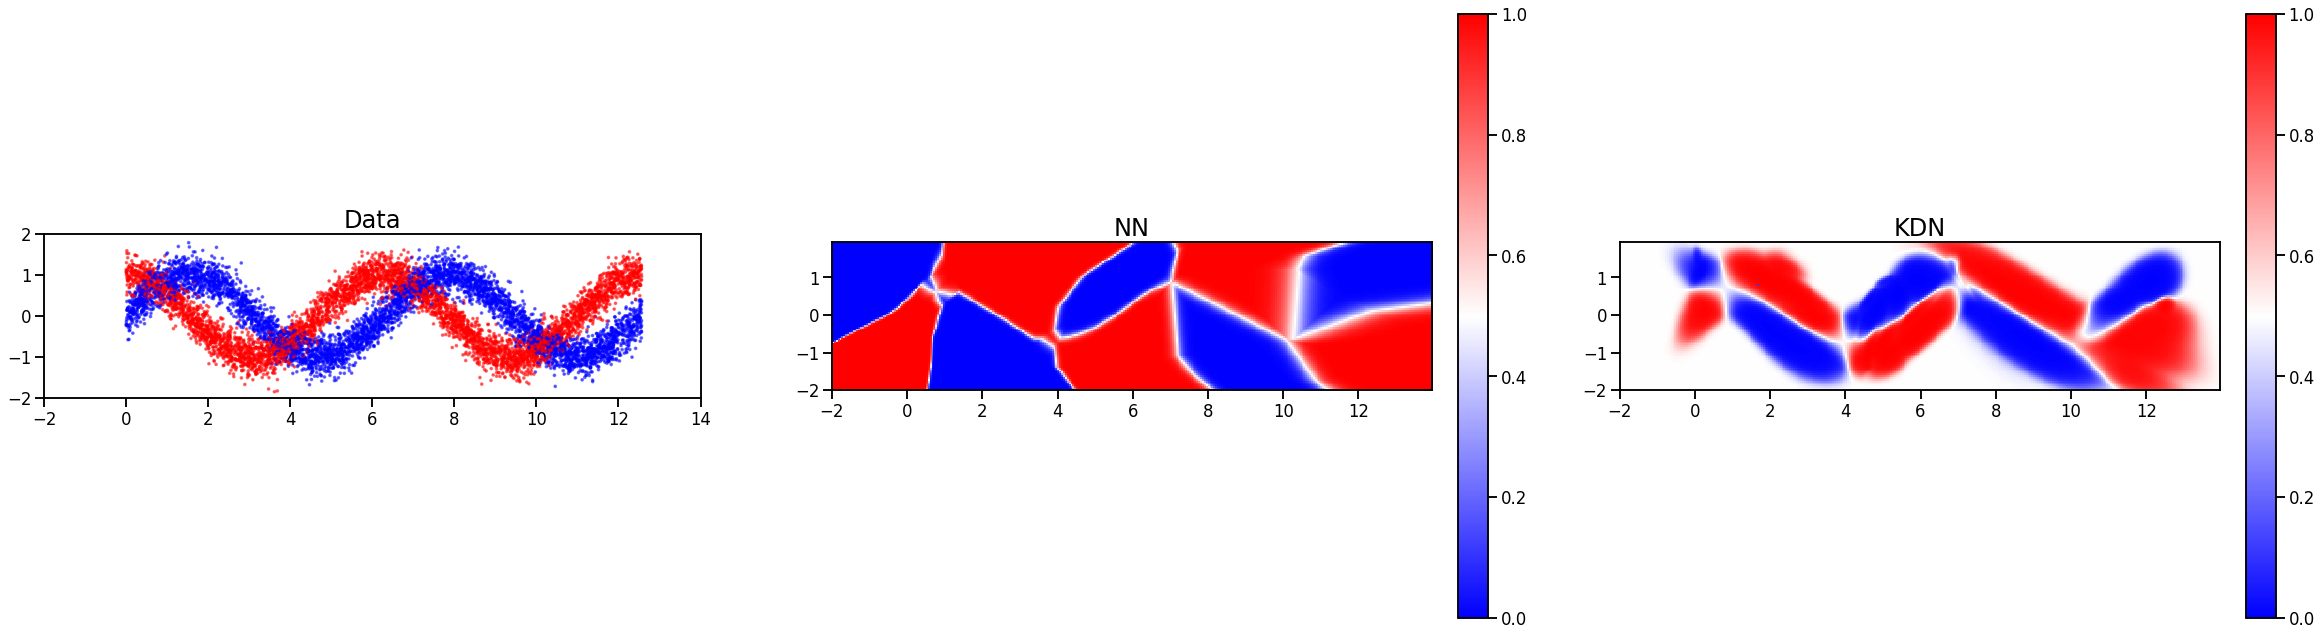

In [533]:
# plot

# plot

# define the grid
p = np.arange(-2, 14, step=0.05)
q = np.arange(-2, 2, step=0.05)
xx, yy = np.meshgrid(p, q)
tmp = np.ones(xx.shape)
grid_samples = np.concatenate((xx.reshape(-1, 1), yy.reshape(-1, 1)), axis=1)

# plot
proba_kdn = model_kdn.predict_proba(grid_samples)
proba_nn = model_kdn.predict_proba_nn(grid_samples)

fig, ax = plt.subplots(1, 3, figsize=(40, 40))

import matplotlib
cmap = matplotlib.cm.get_cmap('bwr')
clr = [cmap(255*i) for i in y]
ax[0].scatter(X[:, 0], X[:, 1], c=clr, s=5, alpha=0.5)
ax[0].set_xlim(-2, 14)
ax[0].set_ylim(-2, 2)
ax[0].set_title("Data", fontsize=24)
ax[0].set_aspect("equal")

ax1 = ax[1].imshow(
    np.flip(proba_nn[:, 0].reshape(80, 320), axis=0),
    extent=[xx.min(), xx.max(), yy.min(), yy.max()],
    cmap="bwr",
    vmin=0,
    vmax=1,
    interpolation="nearest",
    aspect="auto",
)
ax[1].set_title("NN", fontsize=24)
ax[1].set_aspect("equal")
fig.colorbar(ax1, ax=ax[1], fraction=0.046, pad=0.04)

ax2 = ax[2].imshow(
    np.flip(proba_kdn[:, 0].reshape(80, 320), axis=0),
    extent=[xx.min(), xx.max(), yy.min(), yy.max()],
    cmap="bwr",
    vmin=0,
    vmax=1,
    interpolation="nearest",
    aspect="auto",
)
ax[2].set_title("KDN", fontsize=24)
ax[2].set_aspect("equal")
fig.colorbar(ax2, ax=ax[2], fraction=0.046, pad=0.04)

fig.savefig("KDN_pen_w.pdf", bbox_inches='tight')
plt.show()



## KDN with all layer-polytopes (Unweighted)

In [534]:
#
# Created on Thu Dec 09 2021 5:59:36 AM
# Author: Ashwin De Silva (ldesilv2@jhu.edu)
# Objective: Implements the KDN class
#

# import standard libraries
from sklearn.utils.validation import check_array, check_X_y
import numpy as np
from scipy.stats import multivariate_normal
from sklearn.covariance import LedoitWolf
import matplotlib.pyplot as plt


class kdn_all_unw():
    def __init__(
        self,
        network,
        k=1,
        polytope_compute_method="all",
        weighting_method="lin",
        T=2,
        c=1,
        verbose=True,
    ):
        """Kernel Density Network

        Parameters
        ----------
        network : Keras Model
            trained neural network model
        k : int, optional
            bias tuning parameter, by default 1
        polytope_compute_method : str, optional
            select the polytope compute method, by default 'all'
        T : int, optional
            polytope size threshold, by default 2
        c : int, optional
            weight tuning parameter, by default 1
        weighting : bool, optional
            select the weighting scheme, by default True
        verbose : bool, optional
            display meta data, by default True
        """

        super().__init__()
        self.polytope_means = {}
        self.polytope_cov = {}
        self.network = network
        self.k = k
        self.c = c
        self.polytope_compute_method = polytope_compute_method
        self.T = T
        self.weighting_method = weighting_method
        self.bias = {}
        self.verbose = verbose

        # total number of layers in the NN
        self.total_layers = len(self.network.layers)

        # get the layer sizes of each layer
        self.network_shape = []
        for layer in network.layers:
            self.network_shape.append(layer.output_shape[-1])

        # get the weights and biases of the trained MLP
        self.weights = {}
        self.biases = {}
        for i in range(len(self.network.layers)):
            weight, bias = self.network.layers[i].get_weights()
            self.weights[i], self.biases[i] = weight, bias.reshape(1, -1)

    def _get_polytope_memberships(self, X):
        r"""
        Obtain the polytope ID of each input sample
        Parameters
        ----------
        X : ndarray
            Input data matrix.
        """
        polytope_memberships = []
        last_activations = X

        # Iterate through neural network manually, getting node activations at each step
        for layer_id in range(self.total_layers):
            weights, bias = self.network.layers[layer_id].get_weights()

            # Calculate new activations based on input to this layer
            preactivation = np.matmul(last_activations, weights) + bias

            # get list of activated nodes in this layer
            if layer_id == self.total_layers - 1:
                binary_preactivation = (preactivation > 0.5).astype("int")
            else:
                binary_preactivation = (preactivation > 0).astype("int")

            if self.polytope_compute_method == "pl":
                # determine the polytope memberships only based on the penultimate layer (uncomment )
                if layer_id == self.total_layers - 2:
                    polytope_memberships.append(binary_preactivation)

            if self.polytope_compute_method == "all":
                # determine the polytope memberships only based on all the FC layers (uncomment)
                if layer_id < self.total_layers - 1:
                    polytope_memberships.append(binary_preactivation)

            # remove all nodes that were not activated
            last_activations = preactivation * binary_preactivation

        # Concatenate all activations for given observation
        polytope_obs = np.concatenate(polytope_memberships, axis=1)
        polytope_memberships = [
            np.tensordot(
                polytope_obs, 2 ** np.arange(0, np.shape(polytope_obs)[1]), axes=1
            )
        ]

        self.num_fc_neurons = polytope_obs.shape[
            1
        ]  # get the number of total FC neurons under consideration

        return polytope_memberships

    def _get_activation_pattern(self, polytope_id):
        """get the ReLU activation pattern given the polytope ID

        Parameters
        ----------
        polytope_id : int
            polytope identifier

        Returns
        -------
        ndarray
            ReLU activation pattern (binary) corresponding to the given polytope ID
        """
        binary_string = np.binary_repr(polytope_id, width=self.num_fc_neurons)[::-1]
        return np.array(list(binary_string)).astype("int")
        
    def compute_weights(self, X, X_ref):
        """compute weights based on the global network linearity measure

        Parameters
        ----------
        X_ : ndarray
            Input data matrix
        polytope_id : int
            refernce polytope identifier

        Returns
        -------
        ndarray
            weights of each input sample in the input data matrix
        """

        A = X
        for l in range(len(self.network_shape)-1):
            W, B = self.weights[l], self.biases[l]
            pre_A = A @ W + B
            A = np.maximum(0, pre_A)
        
        A_ref = X_ref
        for l in range(len(self.network_shape)-1):
            W, B = self.weights[l], self.biases[l]
            pre_A_ref = A_ref @ W + B
            A_ref = np.maximum(0, pre_A_ref)

        d = np.linalg.norm(A - A_ref, axis=1, ord=2)
        return np.exp(-self.c * d)

    def fit(self, X, y):
        r"""
        Fits the kernel density network
        Parameters
        ----------
        X : ndarray
            Input data matrix.
        y : ndarray
            Output (i.e. response) data matrix.
        """
        X, y = check_X_y(X, y)
        self.labels = np.unique(y)

        feature_dim = X.shape[1]

        for label in self.labels:
            self.polytope_means[label] = []
            self.polytope_cov[label] = []

            X_ = X[np.where(y == label)[0]]
            polytope_memberships = self._get_polytope_memberships(X_)[0]
            unique_polytope_ids = np.unique(
                polytope_memberships
            )  # get the unique polytopes

            if self.verbose:
                print("Number of Polytopes : ", len(polytope_memberships))
                print("Number of Unique Polytopes : ", len(unique_polytope_ids))

            polytope_member_count = []  # store the polytope member counts

            for (
                idxx
            ) in range(
                len(polytope_memberships)
            ):  # fit Gaussians for each unique non-singleton polytopes

                idx = np.where(polytope_memberships == polytope_memberships[idxx])[0]

                polytope_size = len(idx)
                polytope_member_count.append(polytope_size)

                if (
                    polytope_size < self.T
                ):  # eliminate polytopes with too few samples within
                    continue

                # apply weights to the data
                X_tmp = X_[idx].copy()

                # compute scales
                scales = np.ones((len(idx), ))

                polytope_mean_ = np.average(
                    X_tmp, axis=0, weights=scales
                )  # compute the weighted average of the samples
                X_tmp -= polytope_mean_  # center the data

                sqrt_scales = np.sqrt(scales).reshape(-1, 1) @ np.ones(
                    feature_dim
                ).reshape(1, -1)
                X_tmp *= sqrt_scales  # scale the centered data with the square root of the weights

                # compute the covariance matrix of the underlying Gaussian using Ledoit-Wolf estimator

                covariance_model = LedoitWolf(assume_centered=True)
                covariance_model.fit(X_tmp)
                polytope_cov_ = covariance_model.covariance_ * len(scales) / sum(scales)

                # store the mean and covariances
                self.polytope_means[label].append(polytope_mean_)
                self.polytope_cov[label].append(polytope_cov_)

            ## calculate bias for each label
            likelihoods = np.zeros((np.size(X_, 0)), dtype=float)

            for polytope_idx, _ in enumerate(self.polytope_means[label]):
                likelihoods += np.nan_to_num(self._compute_pdf(X_, label, polytope_idx))

            likelihoods /= X_.shape[0]
            self.bias[label] = np.min(likelihoods) / (self.k * X_.shape[0])

            if self.verbose:
                plt.hist(polytope_member_count, bins=30)
                plt.xlabel("Number of Members")
                plt.ylabel("Number of Polytopes")
                plt.show()

    def _compute_pdf(self, X, label, polytope_idx):
        """compute the likelihood for the given data

        Parameters
        ----------
        X : ndarray
            Input data matrix
        label : int
            class label
        polytope_idx : int
            polytope identifier

        Returns
        -------
        ndarray
            likelihoods
        """
        polytope_mean = self.polytope_means[label][polytope_idx]
        polytope_cov = self.polytope_cov[label][polytope_idx]

        var = multivariate_normal(
            mean=polytope_mean, cov=polytope_cov, allow_singular=True
        )

        likelihood = var.pdf(X)
        return likelihood

    def predict_proba(self, X):
        r"""
        Calculate posteriors using the kernel density forest.
        Parameters
        ----------
        X : ndarray
            Input data matrix.
        """
        X = check_array(X)

        likelihoods = np.zeros((np.size(X, 0), len(self.labels)), dtype=float)

        for ii, label in enumerate(self.labels):
            total_polytopes = len(self.polytope_means[label])
            for polytope_idx, _ in enumerate(self.polytope_means[label]):
                likelihoods[:, ii] += np.nan_to_num(
                    self._compute_pdf(X, label, polytope_idx)
                )

            likelihoods[:, ii] = likelihoods[:, ii] / total_polytopes
            likelihoods[:, ii] += min(self.bias.values())

        proba = (likelihoods.T / (np.sum(likelihoods, axis=1) + 1e-100)).T
        return proba

    def predict_proba_nn(self, X):
        r"""
        Calculate posteriors using the vanilla NN
        Parameters
        ----------
        X : ndarray
            Input data matrix.
        """
        X = check_array(X)

        proba = self.network.predict(X)
        return proba

    def predict(self, X):
        r"""
        Perform inference using the kernel density forest.
        Parameters
        ----------
        X : ndarray
            Input data matrix.
        """
        return np.argmax(self.predict_proba(X), axis=1)


In [535]:
model_kdn = kdn_all_unw(
    network=nn,
    polytope_compute_method='all',
    k=1e-5,
    c=1,
    verbose=False
)
model_kdn.fit(X, y)

In [536]:
print(
    np.mean(model_kdn.predict(X_test)==y_test)
)

0.902


In [537]:
print(
    np.mean(np.argmax(nn.predict(X_test), axis=1) == y_test)
)

0.896


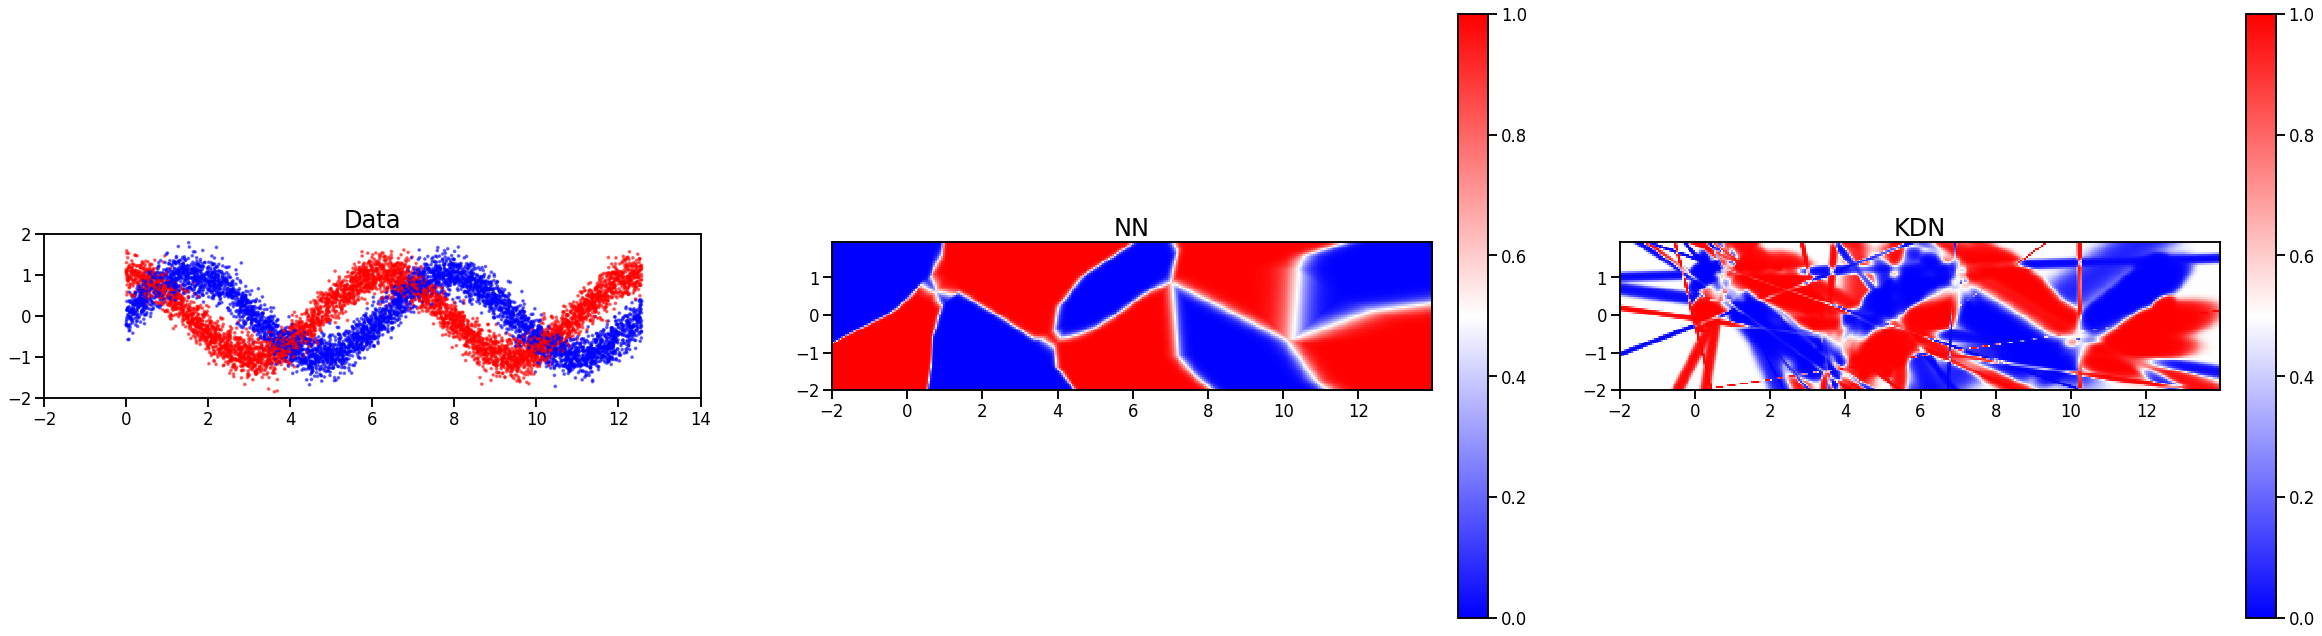

In [538]:
# plot

# define the grid
p = np.arange(-2, 14, step=0.05)
q = np.arange(-2, 2, step=0.05)
xx, yy = np.meshgrid(p, q)
tmp = np.ones(xx.shape)
grid_samples = np.concatenate((xx.reshape(-1, 1), yy.reshape(-1, 1)), axis=1)

# plot
proba_kdn = model_kdn.predict_proba(grid_samples)
proba_nn = model_kdn.predict_proba_nn(grid_samples)

fig, ax = plt.subplots(1, 3, figsize=(40, 40))

import matplotlib
cmap = matplotlib.cm.get_cmap('bwr')
clr = [cmap(255*i) for i in y]
ax[0].scatter(X[:, 0], X[:, 1], c=clr, s=5, alpha=0.5)
ax[0].set_xlim(-2, 14)
ax[0].set_ylim(-2, 2)
ax[0].set_title("Data", fontsize=24)
ax[0].set_aspect("equal")

ax1 = ax[1].imshow(
    np.flip(proba_nn[:, 0].reshape(80, 320), axis=0),
    extent=[xx.min(), xx.max(), yy.min(), yy.max()],
    cmap="bwr",
    vmin=0,
    vmax=1,
    interpolation="nearest",
    aspect="auto",
)
ax[1].set_title("NN", fontsize=24)
ax[1].set_aspect("equal")
fig.colorbar(ax1, ax=ax[1], fraction=0.046, pad=0.04)

ax2 = ax[2].imshow(
    np.flip(proba_kdn[:, 0].reshape(80, 320), axis=0),
    extent=[xx.min(), xx.max(), yy.min(), yy.max()],
    cmap="bwr",
    vmin=0,
    vmax=1,
    interpolation="nearest",
    aspect="auto",
)
ax[2].set_title("KDN", fontsize=24)
ax[2].set_aspect("equal")
fig.colorbar(ax2, ax=ax[2], fraction=0.046, pad=0.04)

fig.savefig("KDN_all_unw.pdf", bbox_inches='tight')
plt.show()



## KDN with all layer-polytopes (Weighted)

In [571]:
#
# Created on Thu Dec 09 2021 5:59:36 AM
# Author: Ashwin De Silva (ldesilv2@jhu.edu)
# Objective: Implements the KDN class
#

# import standard libraries
from sklearn.utils.validation import check_array, check_X_y
import numpy as np
from scipy.stats import multivariate_normal
from sklearn.covariance import LedoitWolf
import matplotlib.pyplot as plt


class kdn_all_w():
    def __init__(
        self,
        network,
        k=1,
        polytope_compute_method="all",
        weighting_method="lin",
        T=2,
        c=1,
        verbose=True,
    ):
        """Kernel Density Network

        Parameters
        ----------
        network : Keras Model
            trained neural network model
        k : int, optional
            bias tuning parameter, by default 1
        polytope_compute_method : str, optional
            select the polytope compute method, by default 'all'
        T : int, optional
            polytope size threshold, by default 2
        c : int, optional
            weight tuning parameter, by default 1
        weighting : bool, optional
            select the weighting scheme, by default True
        verbose : bool, optional
            display meta data, by default True
        """

        super().__init__()
        self.polytope_means = {}
        self.polytope_cov = {}
        self.network = network
        self.k = k
        self.c = c
        self.polytope_compute_method = polytope_compute_method
        self.T = T
        self.weighting_method = weighting_method
        self.bias = {}
        self.verbose = verbose

        # total number of layers in the NN
        self.total_layers = len(self.network.layers)

        # get the layer sizes of each layer
        self.network_shape = []
        for layer in network.layers:
            self.network_shape.append(layer.output_shape[-1])

        # get the weights and biases of the trained MLP
        self.weights = {}
        self.biases = {}
        for i in range(len(self.network.layers)):
            weight, bias = self.network.layers[i].get_weights()
            self.weights[i], self.biases[i] = weight, bias.reshape(1, -1)

    def _get_polytope_memberships(self, X):
        r"""
        Obtain the polytope ID of each input sample
        Parameters
        ----------
        X : ndarray
            Input data matrix.
        """
        polytope_memberships = []
        last_activations = X

        # Iterate through neural network manually, getting node activations at each step
        for layer_id in range(self.total_layers):
            weights, bias = self.network.layers[layer_id].get_weights()

            # Calculate new activations based on input to this layer
            preactivation = np.matmul(last_activations, weights) + bias

            # get list of activated nodes in this layer
            if layer_id == self.total_layers - 1:
                binary_preactivation = (preactivation > 0.5).astype("int")
            else:
                binary_preactivation = (preactivation > 0).astype("int")

            if self.polytope_compute_method == "pl":
                # determine the polytope memberships only based on the penultimate layer (uncomment )
                if layer_id == self.total_layers - 2:
                    polytope_memberships.append(binary_preactivation)

            if self.polytope_compute_method == "all":
                # determine the polytope memberships only based on all the FC layers (uncomment)
                if layer_id < self.total_layers - 1:
                    polytope_memberships.append(binary_preactivation)

            # remove all nodes that were not activated
            last_activations = preactivation * binary_preactivation

        # Concatenate all activations for given observation
        polytope_obs = np.concatenate(polytope_memberships, axis=1)
        polytope_memberships = [
            np.tensordot(
                polytope_obs, 2 ** np.arange(0, np.shape(polytope_obs)[1]), axes=1
            )
        ]

        self.num_fc_neurons = polytope_obs.shape[
            1
        ]  # get the number of total FC neurons under consideration

        return polytope_memberships

    def _get_activation_pattern(self, polytope_id):
        """get the ReLU activation pattern given the polytope ID

        Parameters
        ----------
        polytope_id : int
            polytope identifier

        Returns
        -------
        ndarray
            ReLU activation pattern (binary) corresponding to the given polytope ID
        """
        binary_string = np.binary_repr(polytope_id, width=self.num_fc_neurons)[::-1]
        return np.array(list(binary_string)).astype("int")
        
    def compute_weights(self, X, X_ref):
        """compute weights based on the global network linearity measure

        Parameters
        ----------
        X_ : ndarray
            Input data matrix
        polytope_id : int
            refernce polytope identifier

        Returns
        -------
        ndarray
            weights of each input sample in the input data matrix
        """

        A = X
        A_ref = X_ref
        d = 0
        for l in range(len(self.network_shape)-1):
            W, B = self.weights[l], self.biases[l]
            pre_A = A @ W + B
            pre_A_ref = A_ref @ W + B
            A = np.maximum(0, pre_A)
            A_ref = np.maximum(0, pre_A_ref)
            d += np.linalg.norm(A - A_ref, axis=1, ord=2)
        return np.exp(-self.c * d)

    def fit(self, X, y):
        r"""
        Fits the kernel density network
        Parameters
        ----------
        X : ndarray
            Input data matrix.
        y : ndarray
            Output (i.e. response) data matrix.
        """
        X, y = check_X_y(X, y)
        self.labels = np.unique(y)

        feature_dim = X.shape[1]

        for label in self.labels:
            self.polytope_means[label] = []
            self.polytope_cov[label] = []

            X_ = X[np.where(y == label)[0]]
            polytope_memberships = self._get_polytope_memberships(X_)[0]
            unique_polytope_ids = np.unique(
                polytope_memberships
            )  # get the unique polytopes

            if self.verbose:
                print("Number of Polytopes : ", len(polytope_memberships))
                print("Number of Unique Polytopes : ", len(unique_polytope_ids))

            polytope_member_count = []  # store the polytope member counts

            for (
                idxx
            ) in range(
                len(polytope_memberships)
            ):  # fit Gaussians for each unique non-singleton polytopes

                idx = np.where(polytope_memberships == polytope_memberships[idxx])[0]

                polytope_size = len(idx)
                polytope_member_count.append(polytope_size)

                if (
                    polytope_size < self.T
                ):  # eliminate polytopes with too few samples within
                    continue

                # apply weights to the data
                X_tmp = X_[idx].copy()

                # # compute scales
                scales = self.compute_weights(X_tmp, X_[idxx])

                polytope_mean_ = np.average(
                    X_tmp, axis=0, weights=scales
                )  # compute the weighted average of the samples
                X_tmp -= polytope_mean_  # center the data

                sqrt_scales = np.sqrt(scales).reshape(-1, 1) @ np.ones(
                    feature_dim
                ).reshape(1, -1)
                X_tmp *= sqrt_scales  # scale the centered data with the square root of the weights

                # compute the covariance matrix of the underlying Gaussian using Ledoit-Wolf estimator

                covariance_model = LedoitWolf(assume_centered=True)
                covariance_model.fit(X_tmp)
                polytope_cov_ = covariance_model.covariance_ * len(scales) / sum(scales)

                # store the mean and covariances
                self.polytope_means[label].append(polytope_mean_)
                self.polytope_cov[label].append(polytope_cov_)

            ## calculate bias for each label
            likelihoods = np.zeros((np.size(X_, 0)), dtype=float)

            for polytope_idx, _ in enumerate(self.polytope_means[label]):
                likelihoods += np.nan_to_num(self._compute_pdf(X_, label, polytope_idx))

            likelihoods /= X_.shape[0]
            self.bias[label] = np.min(likelihoods) / (self.k * X_.shape[0])

            if self.verbose:
                plt.hist(polytope_member_count, bins=30)
                plt.xlabel("Number of Members")
                plt.ylabel("Number of Polytopes")
                plt.show()

    def _compute_pdf(self, X, label, polytope_idx):
        """compute the likelihood for the given data

        Parameters
        ----------
        X : ndarray
            Input data matrix
        label : int
            class label
        polytope_idx : int
            polytope identifier

        Returns
        -------
        ndarray
            likelihoods
        """
        polytope_mean = self.polytope_means[label][polytope_idx]
        polytope_cov = self.polytope_cov[label][polytope_idx]

        var = multivariate_normal(
            mean=polytope_mean, cov=polytope_cov, allow_singular=True
        )

        likelihood = var.pdf(X)
        return likelihood

    def predict_proba(self, X):
        r"""
        Calculate posteriors using the kernel density forest.
        Parameters
        ----------
        X : ndarray
            Input data matrix.
        """
        X = check_array(X)

        likelihoods = np.zeros((np.size(X, 0), len(self.labels)), dtype=float)

        for ii, label in enumerate(self.labels):
            total_polytopes = len(self.polytope_means[label])
            for polytope_idx, _ in enumerate(self.polytope_means[label]):
                likelihoods[:, ii] += np.nan_to_num(
                    self._compute_pdf(X, label, polytope_idx)
                )

            likelihoods[:, ii] = likelihoods[:, ii] / total_polytopes
            likelihoods[:, ii] += min(self.bias.values())
        
        likelihoods = np.exp(likelihoods)
        proba = (likelihoods.T / (np.sum(likelihoods, axis=1) + 1e-100)).T
        return proba

    def predict_proba_nn(self, X):
        r"""
        Calculate posteriors using the vanilla NN
        Parameters
        ----------
        X : ndarray
            Input data matrix.
        """
        X = check_array(X)

        proba = self.network.predict(X)
        return proba

    def predict(self, X):
        r"""
        Perform inference using the kernel density forest.
        Parameters
        ----------
        X : ndarray
            Input data matrix.
        """
        return np.argmax(self.predict_proba(X), axis=1)


In [580]:
model_kdn = kdn_all_w(
    network=nn,
    polytope_compute_method='all',
    k=1e-5,
    c=4,
    verbose=False
)
model_kdn.fit(X, y)

In [581]:
print(
    np.mean(model_kdn.predict(X_test)==y_test)
)

0.913


In [582]:
print(
    np.mean(np.argmax(nn.predict(X_test), axis=1) == y_test)
)

0.904


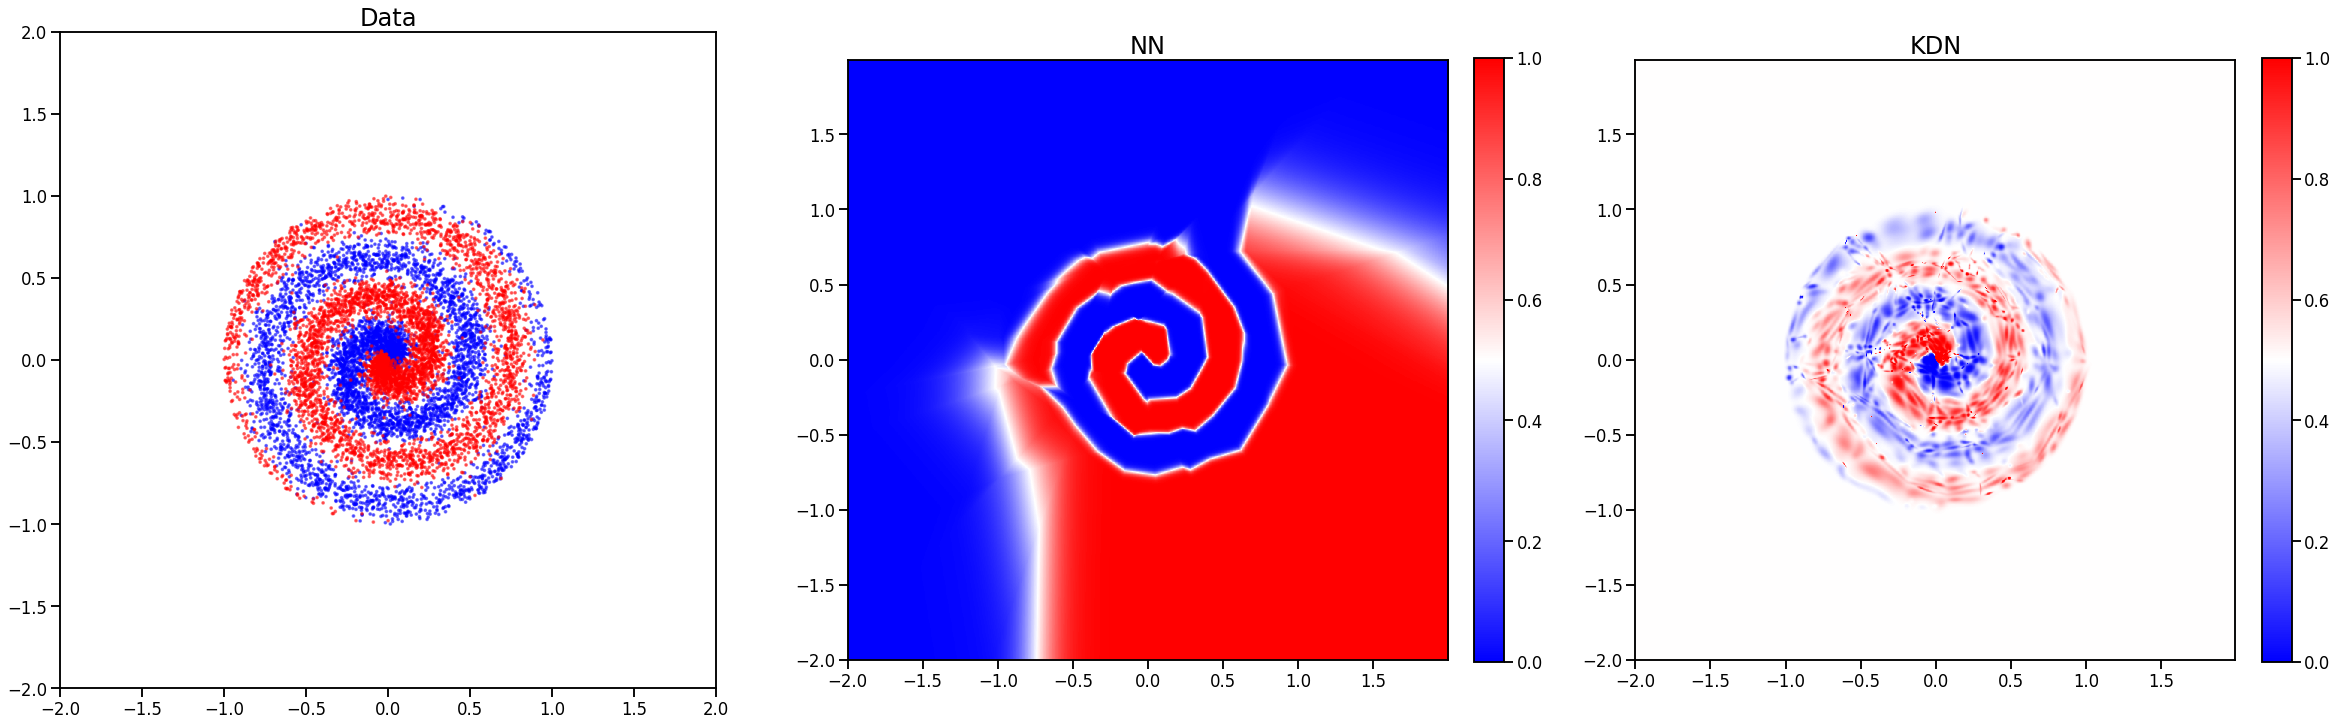

In [584]:
# plot

# define the grid
p = np.arange(-2, 2, step=0.005)
q = np.arange(-2, 2, step=0.005)
xx, yy = np.meshgrid(p, q)
tmp = np.ones(xx.shape)
grid_samples = np.concatenate((xx.reshape(-1, 1), yy.reshape(-1, 1)), axis=1)

# plot
proba_kdn = model_kdn.predict_proba(grid_samples)
proba_nn = model_kdn.predict_proba_nn(grid_samples)

fig, ax = plt.subplots(1, 3, figsize=(40, 40))

import matplotlib
cmap = matplotlib.cm.get_cmap('bwr')
clr = [cmap(255*i) for i in y]
ax[0].scatter(X[:, 0], X[:, 1], c=clr, s=5, alpha=0.5)
ax[0].set_xlim(-2, 2)
ax[0].set_ylim(-2, 2)
ax[0].set_title("Data", fontsize=24)
ax[0].set_aspect("equal")

ax1 = ax[1].imshow(
    np.flip(proba_nn[:, 0].reshape(800, 800), axis=0),
    extent=[xx.min(), xx.max(), yy.min(), yy.max()],
    cmap="bwr",
    vmin=0,
    vmax=1,
    interpolation="nearest",
    aspect="auto",
)
ax[1].set_title("NN", fontsize=24)
ax[1].set_aspect("equal")
fig.colorbar(ax1, ax=ax[1], fraction=0.046, pad=0.04)

ax2 = ax[2].imshow(
    np.flip(proba_kdn[:, 0].reshape(800, 800), axis=0),
    extent=[xx.min(), xx.max(), yy.min(), yy.max()],
    cmap="bwr",
    vmin=0,
    vmax=1,
    interpolation="nearest",
    aspect="auto",
)
ax[2].set_title("KDN", fontsize=24)
ax[2].set_aspect("equal")
fig.colorbar(ax2, ax=ax[2], fraction=0.046, pad=0.04)

fig.savefig("KDN_all_w.pdf", bbox_inches='tight')
plt.show()



## KDN all layer-polytopes (Average polytope?)

In [593]:
#
# Created on Thu Dec 09 2021 5:59:36 AM
# Author: Ashwin De Silva (ldesilv2@jhu.edu)
# Objective: Implements the KDN class
#

# import standard libraries
from sklearn.utils.validation import check_array, check_X_y
import numpy as np
from scipy.stats import multivariate_normal
from sklearn.covariance import LedoitWolf
import matplotlib.pyplot as plt


class kdn_all_w_avg_poly():
    def __init__(
        self,
        network,
        k=1,
        polytope_compute_method="all",
        weighting_method="lin",
        T=2,
        c=1,
        verbose=True,
    ):
        """Kernel Density Network

        Parameters
        ----------
        network : Keras Model
            trained neural network model
        k : int, optional
            bias tuning parameter, by default 1
        polytope_compute_method : str, optional
            select the polytope compute method, by default 'all'
        T : int, optional
            polytope size threshold, by default 2
        c : int, optional
            weight tuning parameter, by default 1
        weighting : bool, optional
            select the weighting scheme, by default True
        verbose : bool, optional
            display meta data, by default True
        """

        super().__init__()
        self.polytope_means = {}
        self.polytope_cov = {}
        self.network = network
        self.k = k
        self.c = c
        self.polytope_compute_method = polytope_compute_method
        self.T = T
        self.weighting_method = weighting_method
        self.bias = {}
        self.verbose = verbose

        # total number of layers in the NN
        self.total_layers = len(self.network.layers)

        # get the layer sizes of each layer
        self.network_shape = []
        for layer in network.layers:
            self.network_shape.append(layer.output_shape[-1])

        # get the weights and biases of the trained MLP
        self.weights = {}
        self.biases = {}
        for i in range(len(self.network.layers)):
            weight, bias = self.network.layers[i].get_weights()
            self.weights[i], self.biases[i] = weight, bias.reshape(1, -1)

    def _get_polytope_memberships(self, X):
        r"""
        Obtain the polytope ID of each input sample
        Parameters
        ----------
        X : ndarray
            Input data matrix.
        """
        polytope_memberships = []
        last_activations = X

        # Iterate through neural network manually, getting node activations at each step
        for layer_id in range(self.total_layers):
            weights, bias = self.network.layers[layer_id].get_weights()

            # Calculate new activations based on input to this layer
            preactivation = np.matmul(last_activations, weights) + bias

            # get list of activated nodes in this layer
            if layer_id == self.total_layers - 1:
                binary_preactivation = (preactivation > 0.5).astype("int")
            else:
                binary_preactivation = (preactivation > 0).astype("int")

            if self.polytope_compute_method == "pl":
                # determine the polytope memberships only based on the penultimate layer (uncomment )
                if layer_id == self.total_layers - 2:
                    polytope_memberships.append(binary_preactivation)

            if self.polytope_compute_method == "all":
                # determine the polytope memberships only based on all the FC layers (uncomment)
                if layer_id < self.total_layers - 1:
                    polytope_memberships.append(binary_preactivation)

            # remove all nodes that were not activated
            last_activations = preactivation * binary_preactivation

        # Concatenate all activations for given observation
        polytope_obs = np.concatenate(polytope_memberships, axis=1)
        polytope_memberships = [
            np.tensordot(
                polytope_obs, 2 ** np.arange(0, np.shape(polytope_obs)[1]), axes=1
            )
        ]

        self.num_fc_neurons = polytope_obs.shape[
            1
        ]  # get the number of total FC neurons under consideration

        return polytope_memberships

    def _get_activation_pattern(self, polytope_id):
        """get the ReLU activation pattern given the polytope ID

        Parameters
        ----------
        polytope_id : int
            polytope identifier

        Returns
        -------
        ndarray
            ReLU activation pattern (binary) corresponding to the given polytope ID
        """
        binary_string = np.binary_repr(polytope_id, width=self.num_fc_neurons)[::-1]
        return np.array(list(binary_string)).astype("int")
        
    def compute_weights(self, X, X_ref):
        """compute weights based on the global network linearity measure

        Parameters
        ----------
        X_ : ndarray
            Input data matrix
        polytope_id : int
            refernce polytope identifier

        Returns
        -------
        ndarray
            weights of each input sample in the input data matrix
        """

        A = X
        A_ref = X_ref
        d = 0
        for l in range(len(self.network_shape)-1):
            W, B = self.weights[l], self.biases[l]
            pre_A = A @ W + B
            pre_A_ref = A_ref @ W + B
            A = np.maximum(0, pre_A)
            A_ref = np.maximum(0, pre_A_ref)
            d += np.linalg.norm(A - A_ref, axis=1, ord=2)
        return np.exp(-self.c * d)

    def fit(self, X, y):
        r"""
        Fits the kernel density network
        Parameters
        ----------
        X : ndarray
            Input data matrix.
        y : ndarray
            Output (i.e. response) data matrix.
        """
        X, y = check_X_y(X, y)
        self.labels = np.unique(y)

        feature_dim = X.shape[1]

        for label in self.labels:
            self.polytope_means[label] = []
            self.polytope_cov[label] = []

            X_ = X[np.where(y == label)[0]]
            polytope_memberships = self._get_polytope_memberships(X_)[0]
            unique_polytope_ids = np.unique(
                polytope_memberships
            )  # get the unique polytopes

            if self.verbose:
                print("Number of Polytopes : ", len(polytope_memberships))
                print("Number of Unique Polytopes : ", len(unique_polytope_ids))

            polytope_member_count = []  # store the polytope member counts

            for (
                idxx
            ) in range(
                len(polytope_memberships)
            ):  # fit Gaussians for each unique non-singleton polytopes

                # # compute scales
                scales = self.compute_weights(X_, X_[idxx])
                scales[scales < 1e-3] = 0

                idx = np.where(scales > 0)[0]

                polytope_size = len(idx)
                polytope_member_count.append(polytope_size)

                if (
                    polytope_size < self.T
                ):  # eliminate polytopes with too few samples within
                    continue

                # apply weights to the data
                X_tmp = X_[idx].copy()
                scales = scales[idx]

                polytope_mean_ = np.average(
                    X_tmp, axis=0, weights=scales
                )  # compute the weighted average of the samples
                X_tmp -= polytope_mean_  # center the data

                sqrt_scales = np.sqrt(scales).reshape(-1, 1) @ np.ones(
                    feature_dim
                ).reshape(1, -1)
                X_tmp *= sqrt_scales  # scale the centered data with the square root of the weights

                # compute the covariance matrix of the underlying Gaussian using Ledoit-Wolf estimator

                covariance_model = LedoitWolf(assume_centered=True)
                covariance_model.fit(X_tmp)
                polytope_cov_ = covariance_model.covariance_ * len(scales) / sum(scales)

                # store the mean and covariances
                self.polytope_means[label].append(polytope_mean_)
                self.polytope_cov[label].append(polytope_cov_)

            ## calculate bias for each label
            likelihoods = np.zeros((np.size(X_, 0)), dtype=float)

            for polytope_idx, _ in enumerate(self.polytope_means[label]):
                likelihoods += np.nan_to_num(self._compute_pdf(X_, label, polytope_idx))

            likelihoods /= X_.shape[0]
            self.bias[label] = np.min(likelihoods) / (self.k * X_.shape[0])

            if self.verbose:
                plt.hist(polytope_member_count, bins=30)
                plt.xlabel("Number of Members")
                plt.ylabel("Number of Polytopes")
                plt.show()

    def _compute_pdf(self, X, label, polytope_idx):
        """compute the likelihood for the given data

        Parameters
        ----------
        X : ndarray
            Input data matrix
        label : int
            class label
        polytope_idx : int
            polytope identifier

        Returns
        -------
        ndarray
            likelihoods
        """
        polytope_mean = self.polytope_means[label][polytope_idx]
        polytope_cov = self.polytope_cov[label][polytope_idx]

        var = multivariate_normal(
            mean=polytope_mean, cov=polytope_cov, allow_singular=True
        )

        likelihood = var.pdf(X)
        return likelihood

    def predict_proba(self, X):
        r"""
        Calculate posteriors using the kernel density forest.
        Parameters
        ----------
        X : ndarray
            Input data matrix.
        """
        X = check_array(X)

        likelihoods = np.zeros((np.size(X, 0), len(self.labels)), dtype=float)

        for ii, label in enumerate(self.labels):
            total_polytopes = len(self.polytope_means[label])
            for polytope_idx, _ in enumerate(self.polytope_means[label]):
                likelihoods[:, ii] += np.nan_to_num(
                    self._compute_pdf(X, label, polytope_idx)
                )

            likelihoods[:, ii] = likelihoods[:, ii] / total_polytopes
            likelihoods[:, ii] += min(self.bias.values())

        likelihoods = np.exp(likelihoods)
        proba = (likelihoods.T / (np.sum(likelihoods, axis=1) + 1e-100)).T
        return proba

    def predict_proba_nn(self, X):
        r"""
        Calculate posteriors using the vanilla NN
        Parameters
        ----------
        X : ndarray
            Input data matrix.
        """
        X = check_array(X)

        proba = self.network.predict(X)
        return proba

    def predict(self, X):
        r"""
        Perform inference using the kernel density forest.
        Parameters
        ----------
        X : ndarray
            Input data matrix.
        """
        return np.argmax(self.predict_proba(X), axis=1)


In [594]:
model_kdn = kdn_all_w_avg_poly(
    network=nn,
    polytope_compute_method='all',
    k=1e-5,
    c=2,
    verbose=False
)
model_kdn.fit(X, y)

In [595]:
print(
    np.mean(model_kdn.predict(X_test)==y_test)
)

0.881


In [596]:
print(
    np.mean(np.argmax(nn.predict(X_test), axis=1) == y_test)
)

0.904


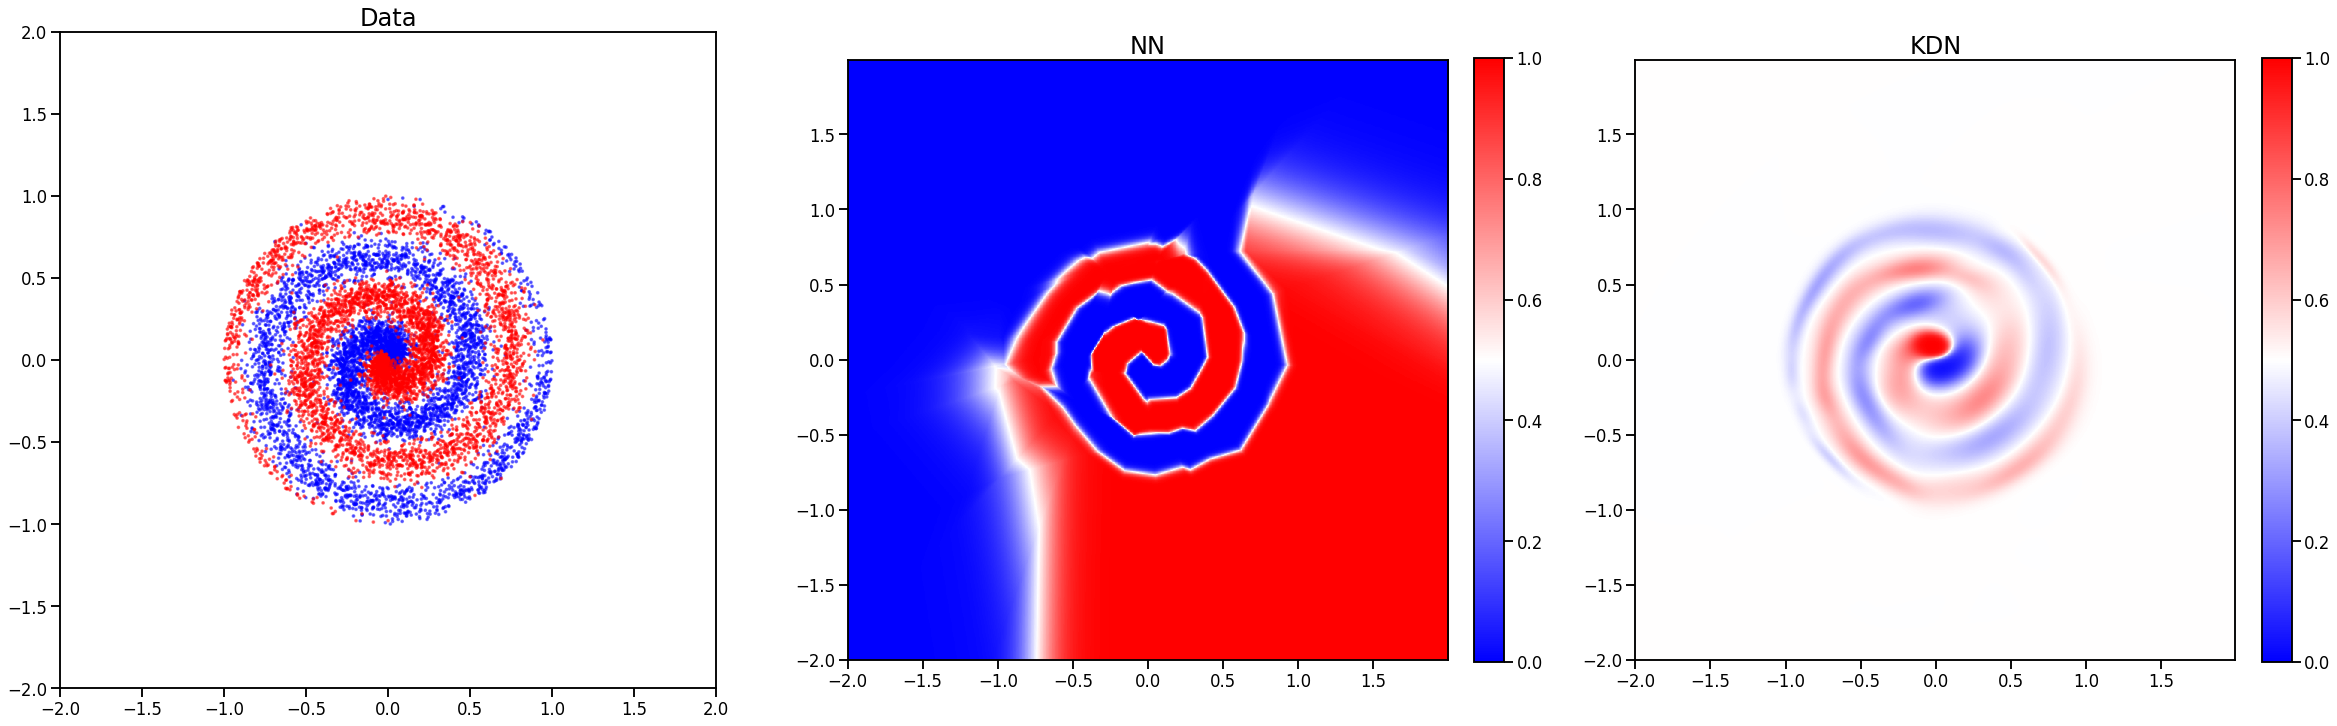

In [599]:
# plot

# define the grid
p = np.arange(-2, 2, step=0.005)
q = np.arange(-2, 2, step=0.005)
xx, yy = np.meshgrid(p, q)
tmp = np.ones(xx.shape)
grid_samples = np.concatenate((xx.reshape(-1, 1), yy.reshape(-1, 1)), axis=1)

# # plot
# proba_kdn = model_kdn.predict_proba(grid_samples)
# proba_nn = model_kdn.predict_proba_nn(grid_samples)

fig, ax = plt.subplots(1, 3, figsize=(40, 40))

import matplotlib
cmap = matplotlib.cm.get_cmap('bwr')
clr = [cmap(255*i) for i in y]
ax[0].scatter(X[:, 0], X[:, 1], c=clr, s=5, alpha=0.5)
ax[0].set_xlim(-2, 2)
ax[0].set_ylim(-2, 2)
ax[0].set_title("Data", fontsize=24)
ax[0].set_aspect("equal")

ax1 = ax[1].imshow(
    np.flip(proba_nn[:, 0].reshape(800, 800), axis=0),
    extent=[xx.min(), xx.max(), yy.min(), yy.max()],
    cmap="bwr",
    vmin=0,
    vmax=1,
    interpolation="nearest",
    aspect="auto",
)
ax[1].set_title("NN", fontsize=24)
ax[1].set_aspect("equal")
fig.colorbar(ax1, ax=ax[1], fraction=0.046, pad=0.04)

ax2 = ax[2].imshow(
    np.flip(proba_kdn[:, 0].reshape(800, 800), axis=0),
    extent=[xx.min(), xx.max(), yy.min(), yy.max()],
    cmap="bwr",
    vmin=0,
    vmax=1,
    interpolation="nearest",
    aspect="auto",
)
ax[2].set_title("KDN", fontsize=24)
ax[2].set_aspect("equal")
fig.colorbar(ax2, ax=ax[2], fraction=0.046, pad=0.04)

fig.savefig("KDN_all_w_avg.pdf", bbox_inches='tight')
plt.show()


## KDN all layer-polytopes (Hacky Method)

In [585]:
#
# Created on Thu Dec 09 2021 5:59:36 AM
# Author: Ashwin De Silva (ldesilv2@jhu.edu)
# Objective: Implements the KDN class
#

# import standard libraries
from sklearn.utils.validation import check_array, check_X_y
import numpy as np
from scipy.stats import multivariate_normal
from sklearn.covariance import LedoitWolf
import matplotlib.pyplot as plt


class kdn_all_hacky():
    def __init__(
        self,
        network,
        k=1,
        polytope_compute_method="all",
        weighting_method="lin",
        T=2,
        c=1,
        verbose=True,
    ):
        """Kernel Density Network

        Parameters
        ----------
        network : Keras Model
            trained neural network model
        k : int, optional
            bias tuning parameter, by default 1
        polytope_compute_method : str, optional
            select the polytope compute method, by default 'all'
        T : int, optional
            polytope size threshold, by default 2
        c : int, optional
            weight tuning parameter, by default 1
        weighting : bool, optional
            select the weighting scheme, by default True
        verbose : bool, optional
            display meta data, by default True
        """

        super().__init__()
        self.polytope_means = {}
        self.polytope_cov = {}
        self.network = network
        self.k = k
        self.c = c
        self.polytope_compute_method = polytope_compute_method
        self.T = T
        self.weighting_method = weighting_method
        self.bias = {}
        self.verbose = verbose

        # total number of layers in the NN
        self.total_layers = len(self.network.layers)

        # get the layer sizes of each layer
        self.network_shape = []
        for layer in network.layers:
            self.network_shape.append(layer.output_shape[-1])

        # get the weights and biases of the trained MLP
        self.weights = {}
        self.biases = {}
        for i in range(len(self.network.layers)):
            weight, bias = self.network.layers[i].get_weights()
            self.weights[i], self.biases[i] = weight, bias.reshape(1, -1)

    def _get_polytope_memberships(self, X):
        r"""
        Obtain the polytope ID of each input sample
        Parameters
        ----------
        X : ndarray
            Input data matrix.
        """
        polytope_memberships = []
        last_activations = X

        # Iterate through neural network manually, getting node activations at each step
        for layer_id in range(self.total_layers):
            weights, bias = self.network.layers[layer_id].get_weights()

            # Calculate new activations based on input to this layer
            preactivation = np.matmul(last_activations, weights) + bias

            # get list of activated nodes in this layer
            if layer_id == self.total_layers - 1:
                binary_preactivation = (preactivation > 0.5).astype("int")
            else:
                binary_preactivation = (preactivation > 0).astype("int")

            if self.polytope_compute_method == "pl":
                # determine the polytope memberships only based on the penultimate layer (uncomment )
                if layer_id == self.total_layers - 2:
                    polytope_memberships.append(binary_preactivation)

            if self.polytope_compute_method == "all":
                # determine the polytope memberships only based on all the FC layers (uncomment)
                if layer_id < self.total_layers - 1:
                    polytope_memberships.append(binary_preactivation)

            # remove all nodes that were not activated
            last_activations = preactivation * binary_preactivation

        # Concatenate all activations for given observation
        polytope_obs = np.concatenate(polytope_memberships, axis=1)
        polytope_memberships = [
            np.tensordot(
                polytope_obs, 2 ** np.arange(0, np.shape(polytope_obs)[1]), axes=1
            )
        ]

        self.num_fc_neurons = polytope_obs.shape[
            1
        ]  # get the number of total FC neurons under consideration

        return polytope_memberships

    def _get_activation_pattern(self, polytope_id):
        """get the ReLU activation pattern given the polytope ID

        Parameters
        ----------
        polytope_id : int
            polytope identifier

        Returns
        -------
        ndarray
            ReLU activation pattern (binary) corresponding to the given polytope ID
        """
        binary_string = np.binary_repr(polytope_id, width=self.num_fc_neurons)[::-1]
        return np.array(list(binary_string)).astype("int")

    def unit_step(self, x):
        """Computes the unit step function output for a given input

        Parameters
        ----------
        x : ndarray
            Input array

        Returns
        -------
        ndarray
            Unit step function output of the input array
        """
        x = np.maximum(x, 0)
        x[x > 0] = 1
        return x

    def compute_weights(self, X_, polytope_id):
        """compute weights based on the global network linearity measure

        Parameters
        ----------
        X_ : ndarray
            Input data matrix
        polytope_id : int
            refernce polytope identifier

        Returns
        -------
        ndarray
            weights of each input sample in the input data matrix
        """
        
        M_ref = self._get_activation_pattern(polytope_id)

        start = 0
        A = X_
        A_ref = X_
        d = 0
        for l in range(len(self.network_shape)-1):
            end = start + self.network_shape[l]
            M_l = M_ref[start:end]
            start = end
            W, B = self.weights[l], self.biases[l]
            pre_A = A @ W + B
            A = np.maximum(0, pre_A)
            pre_A_ref = A_ref @ W + B
            A_ref = pre_A_ref @ np.diag(M_l) 
            d += np.linalg.norm(A - A_ref, axis=1, ord=2)

        return np.exp(-self.c * d)

    def fit(self, X, y):
        r"""
        Fits the kernel density network
        Parameters
        ----------
        X : ndarray
            Input data matrix.
        y : ndarray
            Output (i.e. response) data matrix.
        """
        X, y = check_X_y(X, y)
        self.labels = np.unique(y)

        feature_dim = X.shape[1]

        for label in self.labels:
            self.polytope_means[label] = []
            self.polytope_cov[label] = []

            X_ = X[np.where(y == label)[0]]
            polytope_memberships = self._get_polytope_memberships(X_)[0]
            unique_polytope_ids = np.unique(
                polytope_memberships
            )  # get the unique polytopes

            if self.verbose:
                print("Number of Polytopes : ", len(polytope_memberships))
                print("Number of Unique Polytopes : ", len(unique_polytope_ids))

            polytope_member_count = []  # store the polytope member counts

            for (
                idx
            ) in range(
                len(polytope_memberships)
            ):  # fit Gaussians for each unique non-singleton polytopes

                if self.weighting_method == "lin":
                    # compute weights of the input data samples w.r.t reference polytope
                    weights = self.compute_weights(X_, polytope_memberships[idx])
                elif self.weighting_method == "fm":
                    ########### FM (will be depricated) ################
                    a_native = self._get_activation_pattern(polytope_memberships[idx])
                    weights = []
                    for member_polytope_id in polytope_memberships:
                        a_foreign = self._get_activation_pattern(member_polytope_id)

                        match_status = a_foreign == a_native
                        match_status = match_status.astype("int")

                        if len(np.where(match_status == 0)[0]) == 0:
                            weight = 1.0
                        else:
                            first_mismatch_idx = np.where(match_status == 0)[0][0]
                            weight = first_mismatch_idx / self.num_fc_neurons

                        weights.append(weight)
                    weights = np.array(weights)
                ########### FM (will be depricated) ################
                else:
                    weights = np.zeros((X_.shape[0],))
                    weights[polytope_memberships == polytope_memberships[idx]] = 1

                weights[weights < 1e-3] = 0  # set very small weights to zero

                idxx = np.where(weights > 0)[0]

                polytope_size = len(idxx)
                polytope_member_count.append(polytope_size)

                if (
                    polytope_size < self.T
                ):  # eliminate polytopes with too few samples within
                    continue

                scales = weights[idxx] / np.max(weights[idxx])

                # apply weights to the data
                X_tmp = X_[idxx].copy()
                polytope_mean_ = np.average(
                    X_tmp, axis=0, weights=scales
                )  # compute the weighted average of the samples
                X_tmp -= polytope_mean_  # center the data

                sqrt_scales = np.sqrt(scales).reshape(-1, 1) @ np.ones(
                    feature_dim
                ).reshape(1, -1)
                X_tmp *= sqrt_scales  # scale the centered data with the square root of the weights

                # compute the covariance matrix of the underlying Gaussian using Ledoit-Wolf estimator

                covariance_model = LedoitWolf(assume_centered=True)
                covariance_model.fit(X_tmp)
                polytope_cov_ = covariance_model.covariance_ * len(scales) / sum(scales)

                # store the mean and covariances
                self.polytope_means[label].append(polytope_mean_)
                self.polytope_cov[label].append(polytope_cov_)

            ## calculate bias for each label
            likelihoods = np.zeros((np.size(X_, 0)), dtype=float)

            for polytope_idx, _ in enumerate(self.polytope_means[label]):
                likelihoods += np.nan_to_num(self._compute_pdf(X_, label, polytope_idx))

            likelihoods /= X_.shape[0]
            self.bias[label] = np.min(likelihoods) / (self.k * X_.shape[0])

            if self.verbose:
                plt.hist(polytope_member_count, bins=30)
                plt.xlabel("Number of Members")
                plt.ylabel("Number of Polytopes")
                plt.show()

    def _compute_pdf(self, X, label, polytope_idx):
        """compute the likelihood for the given data

        Parameters
        ----------
        X : ndarray
            Input data matrix
        label : int
            class label
        polytope_idx : int
            polytope identifier

        Returns
        -------
        ndarray
            likelihoods
        """
        polytope_mean = self.polytope_means[label][polytope_idx]
        polytope_cov = self.polytope_cov[label][polytope_idx]

        var = multivariate_normal(
            mean=polytope_mean, cov=polytope_cov, allow_singular=True
        )

        likelihood = var.pdf(X)
        return likelihood

    def predict_proba(self, X):
        r"""
        Calculate posteriors using the kernel density forest.
        Parameters
        ----------
        X : ndarray
            Input data matrix.
        """
        X = check_array(X)

        likelihoods = np.zeros((np.size(X, 0), len(self.labels)), dtype=float)

        for ii, label in enumerate(self.labels):
            total_polytopes = len(self.polytope_means[label])
            for polytope_idx, _ in enumerate(self.polytope_means[label]):
                likelihoods[:, ii] += np.nan_to_num(
                    self._compute_pdf(X, label, polytope_idx)
                )

            likelihoods[:, ii] = likelihoods[:, ii] / total_polytopes
            likelihoods[:, ii] += min(self.bias.values())

        likelihoods = np.exp(likelihoods)
        proba = (likelihoods.T / (np.sum(likelihoods, axis=1) + 1e-100)).T
        return proba

    def predict_proba_nn(self, X):
        r"""
        Calculate posteriors using the vanilla NN
        Parameters
        ----------
        X : ndarray
            Input data matrix.
        """
        X = check_array(X)

        proba = self.network.predict(X)
        return proba

    def predict(self, X):
        r"""
        Perform inference using the kernel density forest.
        Parameters
        ----------
        X : ndarray
            Input data matrix.
        """
        return np.argmax(self.predict_proba(X), axis=1)


In [586]:
model_kdn = kdn_all_hacky(
    network=nn,
    polytope_compute_method='all',
    weighting_method='lin',
    k=1e-5,
    c=2, 
    verbose=False
)
model_kdn.fit(X, y)

In [587]:
print(
    np.mean(model_kdn.predict(X_test)==y_test)
)

0.922


In [588]:
print(
    np.mean(np.argmax(nn.predict(X_test), axis=1) == y_test)
)

0.904


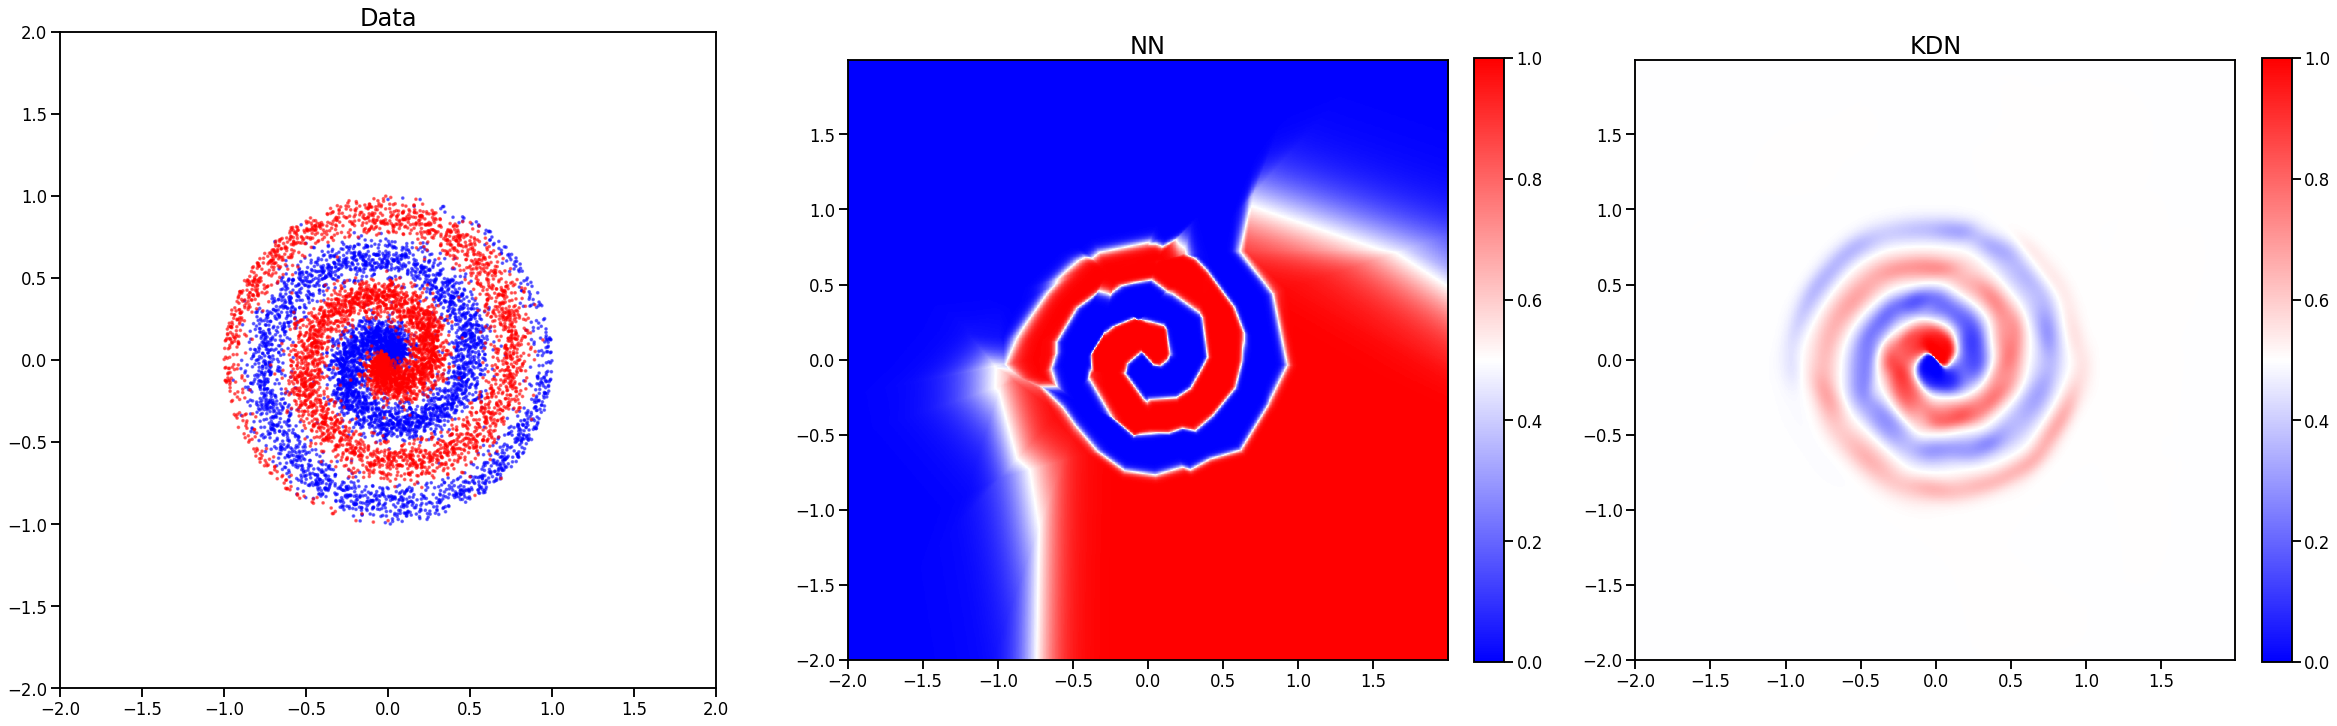

In [589]:
# plot

# define the grid
p = np.arange(-2, 2, step=0.005)
q = np.arange(-2, 2, step=0.005)
xx, yy = np.meshgrid(p, q)
tmp = np.ones(xx.shape)
grid_samples = np.concatenate((xx.reshape(-1, 1), yy.reshape(-1, 1)), axis=1)

# plot
proba_kdn = model_kdn.predict_proba(grid_samples)
proba_nn = model_kdn.predict_proba_nn(grid_samples)

fig, ax = plt.subplots(1, 3, figsize=(40, 40))

import matplotlib
cmap = matplotlib.cm.get_cmap('bwr')
clr = [cmap(255*i) for i in y]
ax[0].scatter(X[:, 0], X[:, 1], c=clr, s=5, alpha=0.5)
ax[0].set_xlim(-2, 2)
ax[0].set_ylim(-2, 2)
ax[0].set_title("Data", fontsize=24)
ax[0].set_aspect("equal")

ax1 = ax[1].imshow(
    np.flip(proba_nn[:, 0].reshape(800, 800), axis=0),
    extent=[xx.min(), xx.max(), yy.min(), yy.max()],
    cmap="bwr",
    vmin=0,
    vmax=1,
    interpolation="nearest",
    aspect="auto",
)
ax[1].set_title("NN", fontsize=24)
ax[1].set_aspect("equal")
fig.colorbar(ax1, ax=ax[1], fraction=0.046, pad=0.04)

ax2 = ax[2].imshow(
    np.flip(proba_kdn[:, 0].reshape(800, 800), axis=0),
    extent=[xx.min(), xx.max(), yy.min(), yy.max()],
    cmap="bwr",
    vmin=0,
    vmax=1,
    interpolation="nearest",
    aspect="auto",
)
ax[2].set_title("KDN", fontsize=24)
ax[2].set_aspect("equal")
fig.colorbar(ax2, ax=ax[2], fraction=0.046, pad=0.04)

fig.savefig("KDN_all_w_hacky.pdf", bbox_inches='tight')
plt.show()



## Sample Size vs. Error Plots

In [590]:
# import pandas as pd
# from kdg.utils import generate_ellipse, generate_polynomial, generate_sinewave, generate_gaussian_parity

In [591]:
# # define the experimental setup
# sample_size = [10, 50, 100, 500, 1000, 5000, 10000]  # sample size under consideration
# n_test = 1000  # test set size
# reps = 5  # number of replicates

# df = pd.DataFrame()
# reps_list = []

# accuracy_kdn_pen_unw = []
# accuracy_kdn_pen_w = []
# accuracy_kdn_all_unw = []
# accuracy_kdn_all_w = []
# accuracy_kdn_all_hack = []
# accuracy_nn = []

# sample_list = []

# X_val, y_val = generate_gaussian_parity(1000)

# # NN params
# compile_kwargs = {
#     "loss": "binary_crossentropy",
#     "optimizer": keras.optimizers.Adam(3e-4),
# }
# callback = keras.callbacks.EarlyStopping(monitor="val_loss", patience=10, verbose=False)
# fit_kwargs = {
#     "epochs": 300,
#     "batch_size": 32,
#     "verbose": False,
#     "validation_data": (X_val, keras.utils.to_categorical(y_val)),
#     "callbacks": [callback],
# }

# # network architecture
# def getNN():
#     initializer = keras.initializers.GlorotNormal(seed=0)
#     network_base = keras.Sequential()
#     network_base.add(keras.layers.Dense(5, activation="relu", kernel_initializer=initializer, input_shape=(2,)))
#     network_base.add(keras.layers.Dense(5, activation="relu", kernel_initializer=initializer))
#     network_base.add(keras.layers.Dense(units=2, activation="softmax", kernel_initializer=initializer))
#     network_base.compile(**compile_kwargs)
#     return network_base

# # run experiment
# for sample in sample_size:
#     print("Doing sample %d" % sample)
#     for ii in range(reps):
#         X, y = generate_gaussian_parity(sample)
#         X_test, y_test = generate_gaussian_parity(n_test)

#         # train Vanilla NN
#         vanilla_nn = getNN()
#         vanilla_nn.fit(X, keras.utils.to_categorical(y), **fit_kwargs)
#         accuracy_nn.append(
#             np.mean(np.argmax(vanilla_nn.predict(X_test), axis=1) == y_test)
#         )

#         # train KDN pen unw
#         model_kdn = kdn_pen_unw(
#             network=nn,
#             polytope_compute_method='pl',
#             k=1e-5,
#             verbose=False
#         )
#         model_kdn.fit(X, y)
#         accuracy_kdn_pen_unw.append(np.mean(model_kdn.predict(X_test) == y_test))

#         # train KDN pen w
#         model_kdn = kdn_pen_w(
#             network=nn,
#             polytope_compute_method='pl',
#             k=1e-5,
#             c=1,
#             verbose=False
#         )
#         model_kdn.fit(X, y)
#         accuracy_kdn_pen_w.append(np.mean(model_kdn.predict(X_test) == y_test))

#         # train KDN all unw
#         model_kdn = kdn_all_unw(
#             network=nn,
#             polytope_compute_method='all',
#             k=1e-5,
#             c=1,
#             verbose=False
#         )
#         model_kdn.fit(X, y)
#         accuracy_kdn_all_unw.append(np.mean(model_kdn.predict(X_test) == y_test))
        
#         # train KDN all w
#         model_kdn = kdn_all_w(
#             network=nn,
#             polytope_compute_method='all',
#             k=1e-5,
#             c=1,
#             verbose=False
#         )
#         model_kdn.fit(X, y)
#         accuracy_kdn_all_w.append(np.mean(model_kdn.predict(X_test) == y_test))
        
#         # train KDN
#         model_kdn = kdn_all_hacky(
#             network=vanilla_nn,
#             polytope_compute_method="all",
#             k=1e-5,
#             weighting_method="lin",
#             T=2,
#             c=1,
#             verbose=False,
#         )
#         model_kdn.fit(X, y)
#         accuracy_kdn_all_hack.append(np.mean(model_kdn.predict(X_test) == y_test))
        
#         reps_list.append(ii)
#         sample_list.append(sample)

# df["accuracy kdn pen unw"] = accuracy_kdn_pen_unw
# df["accuracy kdn pen w"] = accuracy_kdn_pen_w
# df["accuracy kdn all unw"] = accuracy_kdn_all_unw
# df["accuracy kdn all w"] = accuracy_kdn_all_w
# df["accuracy kdn all hack"] = accuracy_kdn_all_hack
# df["accuracy nn"] = accuracy_nn
# df["reps"] = reps_list
# df["sample"] = sample_list

# # save the results (CHANGE HERE)
# df.to_csv("gaussian_parity.csv")

In [592]:
# # Plot the curves

# # Specify which results to plot (CHANGE HERE)
# filename = "gaussian_parity.csv"

# df = pd.read_csv(filename)

# sample_size = [10, 50, 100, 500, 1000, 5000, 10000]

# err_nn_med = []
# err_nn_25_quantile = []
# err_nn_75_quantile = []

# err_kdn_pen_unw_med = []
# err_kdn_pen_unw_25_quantile = []
# err_kdn_pen_unw_75_quantile = []

# err_kdn_pen_w_med = []
# err_kdn_pen_w_25_quantile = []
# err_kdn_pen_w_75_quantile = []

# err_kdn_all_unw_med = []
# err_kdn_all_unw_25_quantile = []
# err_kdn_all_unw_75_quantile = []

# err_kdn_all_w_med = []
# err_kdn_all_w_25_quantile = []
# err_kdn_all_w_75_quantile = []

# err_kdn_all_hack_med = []
# err_kdn_all_hack_25_quantile = []
# err_kdn_all_hack_75_quantile = []

# for sample in sample_size:
#     err_nn = 1 - df["accuracy nn"][df["sample"] == sample]
#     err_kdn_pen_unw = 1 - df["accuracy kdn pen unw"][df["sample"] == sample]
#     err_kdn_pen_w = 1 - df["accuracy kdn pen w"][df["sample"] == sample]
#     err_kdn_all_unw = 1 - df["accuracy kdn all unw"][df["sample"] == sample]
#     err_kdn_all_w = 1 - df["accuracy kdn all w"][df["sample"] == sample]
#     err_kdn_all_hack = 1 - df["accuracy kdn all hack"][df["sample"] == sample]

#     err_nn_med.append(np.median(err_nn))
#     err_nn_25_quantile.append(np.quantile(err_nn, [0.25])[0])
#     err_nn_75_quantile.append(np.quantile(err_nn, [0.75])[0])

#     err_kdn_pen_unw_med.append(np.median(err_kdn_pen_unw))
#     err_kdn_pen_unw_25_quantile.append(np.quantile(err_kdn_pen_unw, [0.25])[0])
#     err_kdn_pen_unw_75_quantile.append(np.quantile(err_kdn_pen_unw, [0.75])[0])

#     err_kdn_pen_w_med.append(np.median(err_kdn_pen_w))
#     err_kdn_pen_w_25_quantile.append(np.quantile(err_kdn_pen_w, [0.25])[0])
#     err_kdn_pen_w_75_quantile.append(np.quantile(err_kdn_pen_w, [0.75])[0])

#     err_kdn_all_unw_med.append(np.median(err_kdn_all_unw))
#     err_kdn_all_unw_25_quantile.append(np.quantile(err_kdn_all_unw, [0.25])[0])
#     err_kdn_all_unw_75_quantile.append(np.quantile(err_kdn_all_unw, [0.75])[0])

#     err_kdn_all_w_med.append(np.median(err_kdn_all_w))
#     err_kdn_all_w_25_quantile.append(np.quantile(err_kdn_all_w, [0.25])[0])
#     err_kdn_all_w_75_quantile.append(np.quantile(err_kdn_all_w, [0.75])[0])

#     err_kdn_all_hack_med.append(np.median(err_kdn_all_hack))
#     err_kdn_all_hack_25_quantile.append(np.quantile(err_kdn_all_hack, [0.25])[0])
#     err_kdn_all_hack_75_quantile.append(np.quantile(err_kdn_all_hack, [0.75])[0])

# sns.set_context("talk")
# fig, ax = plt.subplots(1, 1, figsize=(8, 8))

# ax.plot(sample_size, err_nn_med, c="k", label="NN")
# ax.fill_between(
#     sample_size, err_nn_25_quantile, err_nn_75_quantile, facecolor="k", alpha=0.3
# )

# ax.plot(sample_size, err_kdn_pen_unw_med, c="b", label="KDN pen unw")
# ax.fill_between(
#     sample_size, err_kdn_pen_unw_25_quantile, err_kdn_pen_unw_75_quantile, facecolor="b", alpha=0.3
# )

# ax.plot(sample_size, err_kdn_pen_w_med, c="g", label="KDN pen w")
# ax.fill_between(
#     sample_size, err_kdn_pen_w_25_quantile, err_kdn_pen_w_75_quantile, facecolor="g", alpha=0.3
# )

# ax.plot(sample_size, err_kdn_all_unw_med, c="c", label="KDN all unw")
# ax.fill_between(
#     sample_size, err_kdn_all_unw_25_quantile, err_kdn_all_unw_75_quantile, facecolor="c", alpha=0.3
# )

# ax.plot(sample_size, err_kdn_all_w_med, c="m", label="KDN all w")
# ax.fill_between(
#     sample_size, err_kdn_all_w_25_quantile, err_kdn_all_w_75_quantile, facecolor="m", alpha=0.3
# )

# ax.plot(sample_size, err_kdn_all_hack_med, c="r", label="KDN all hack")
# ax.fill_between(
#     sample_size, err_kdn_all_hack_25_quantile, err_kdn_all_hack_75_quantile, facecolor="r", alpha=0.3
# )

# right_side = ax.spines["right"]
# right_side.set_visible(False)
# top_side = ax.spines["top"]
# top_side.set_visible(False)

# ax.set_xscale("log")
# ax.set_xlabel("Sample size")
# ax.set_ylabel("error")
# ax.legend(frameon=False)

# # Specify the figure save path (CHANGE HERE)
# plt.savefig("gaussian_parity_exp.pdf")
# print("Complete!")
